# Overview of Steps

This notebook performs correlation analysis and other tasks using various datasets related to hydrogen value chains in European countries.

## Steps:

### 1. Import Libraries
- Import necessary libraries for data manipulation, visualization, and statistical analysis.

### 2. Load Datasets
- Load data from CSV files, including merged data and data per million, both with and without additional indexes.

### 3. Data Cleaning
- Fill missing values with zeros.
- Remove unnecessary columns from the datasets.

### 4. Correlation Analysis
- Calculate correlation matrices for both absolute and per million data.
- Create heatmaps to visualize the correlation matrices.

### 5. Scatter Plot Analysis
- Define variable pairs for absolute and per million data.
- Create scatter plots with regression lines for these variable pairs to analyze relationships.

### 6. Combined Plots
- Create and save combined scatter plots for groups of variable pairs.
- Compare both absolute and per million values in the same plots.

### 7. Index Comparison
- Compare hydrogen economy variables with different indices (e.g., competitiveness, renewable energy share).
- Create scatter plots with regression lines for these comparisons.

### 8. Value Chain Analysis
- Calculate the relative and normalized distribution of each country in the hydrogen value chain.
- Create heatmaps to visualize these distributions.

### 9. Radar Charts
- Normalize values for various value chain steps.
- Create radar charts to compare the hydrogen value chain across selected countries.

### 10. Save Visualizations
- Save all generated plots and heatmaps as PNG files for further use and reporting.


# Import data
The data was created in the data_preparation.ipynb notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal

# Load the data
merged_df = pd.read_csv("merged_data/merged_data.csv")
per_million_df = pd.read_csv("merged_data/merged_per_million.csv")
merged_df_index = pd.read_csv("merged_data/merged_data_index.csv", index_col=0)
per_million_df_index = pd.read_csv("merged_data/merged_per_million_index.csv", index_col=0)


Adjust the data so that it works for the following analysis.

In [3]:
#fill "NaN" with 0
merged_df = merged_df.fillna(0)
per_million_df = per_million_df.fillna(0)
merged_df_index = merged_df_index.fillna(0)
per_million_df_index = per_million_df_index.fillna(0)

##drop per_million and 2023 columns
merged_df = merged_df.drop(columns=["per_million"])
merged_df = merged_df.drop(columns=["2023"])
merged_df_index = merged_df_index.drop(columns=["per_million"])
merged_df_index = merged_df_index.drop(columns=["2023"])

In [4]:
data = per_million_df
data = data.drop(columns=["Country"])
# Calculate quartiles for the number of hydrogen valleys
quartiles = data['Hydrogen Valleys'].quantile([0.25, 0.5, 0.75])

# Define categories based on quartiles
def categorize_by_quartiles(valleys, quartiles):
    if valleys <= quartiles[0.25]:
        return 'Low'
    elif valleys <= quartiles[0.5]:
        return 'Medium-Low'
    elif valleys <= quartiles[0.75]:
        return 'Medium-High'
    else:
        return 'High'

data['Valley Category'] = data['Hydrogen Valleys'].apply(lambda x: categorize_by_quartiles(x, quartiles))
data['Valley Category'].value_counts()

Valley Category
Low            8
High           8
Medium-Low     8
Medium-High    7
Name: count, dtype: int64

In [5]:
quartile_category_means = data.groupby('Valley Category').mean().drop(columns=['Hydrogen Valleys'])
quartile_category_means

#create a transposed version of the data
quartile_category_means_t = quartile_category_means.T
quartile_category_means_t

Valley Category,High,Low,Medium-High,Medium-Low
Output T/year,16302.800931,12148.444895,19064.259445,11433.208895
Consumption T/year,16421.008780,12156.698210,18656.514217,11411.439010
Hydrogen Stations,0.844967,0.507255,0.690755,0.589715
FCEV Fleet,18.190119,5.794850,6.257574,3.597405
Employees,360.462042,78.024762,457.263085,267.603762
Companies,10.106189,3.940766,7.871398,4.744821
Research Institutions,0.790934,0.125317,0.341020,0.161816
Value (€/kg),7.131431,7.223832,7.260519,6.785848


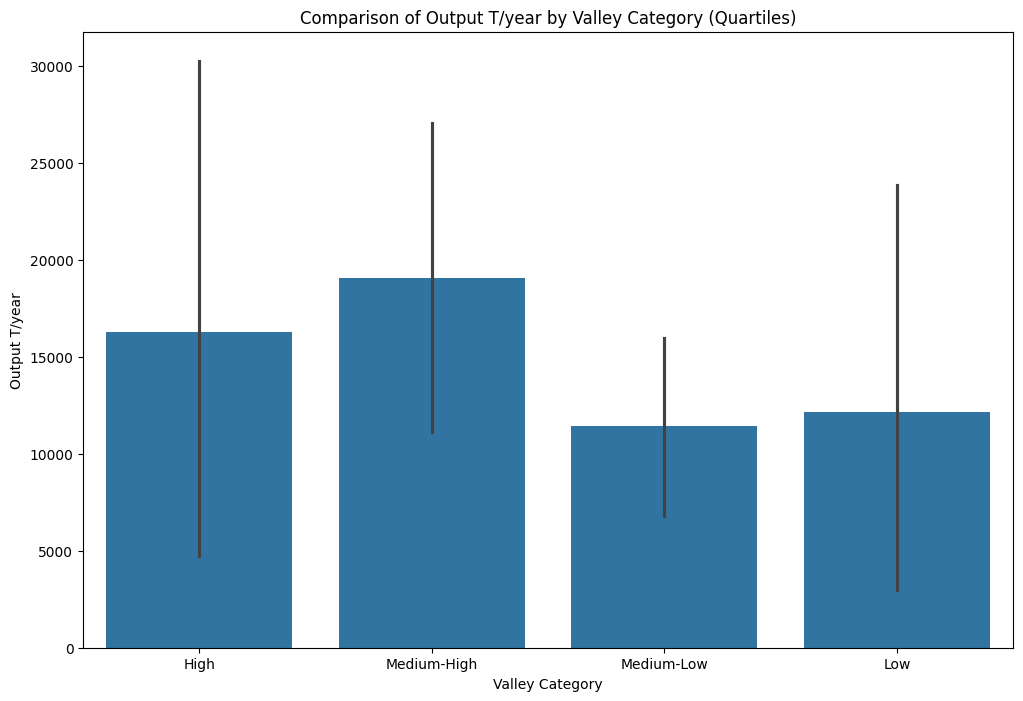

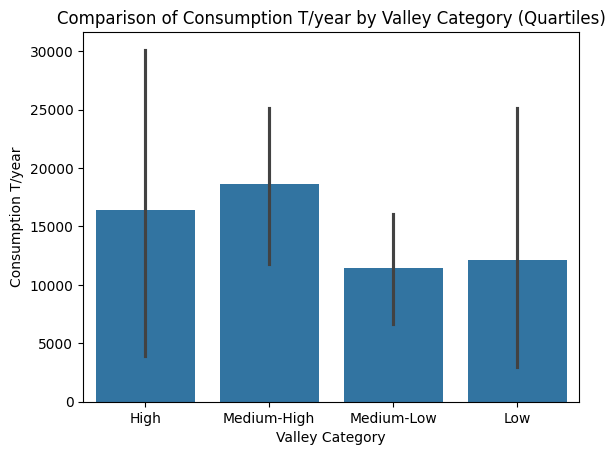

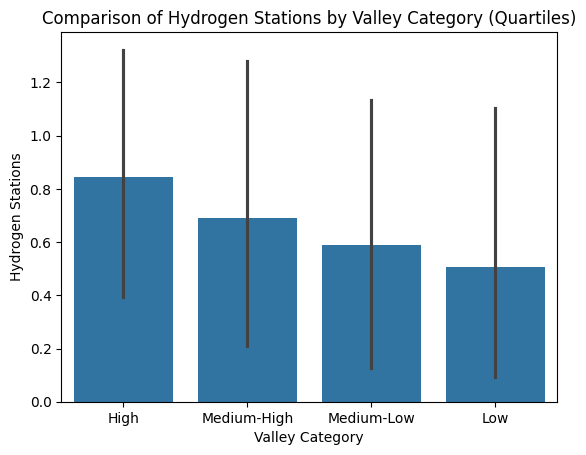

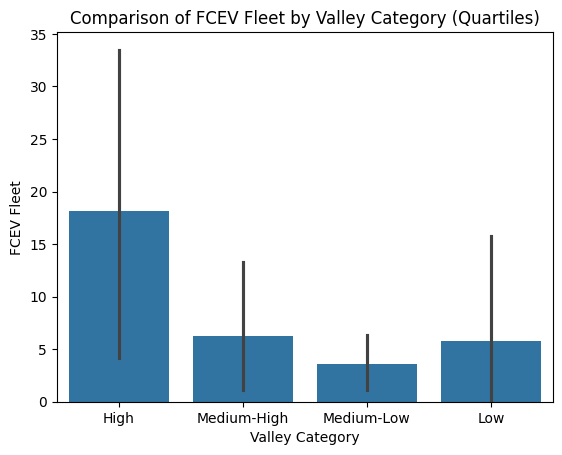

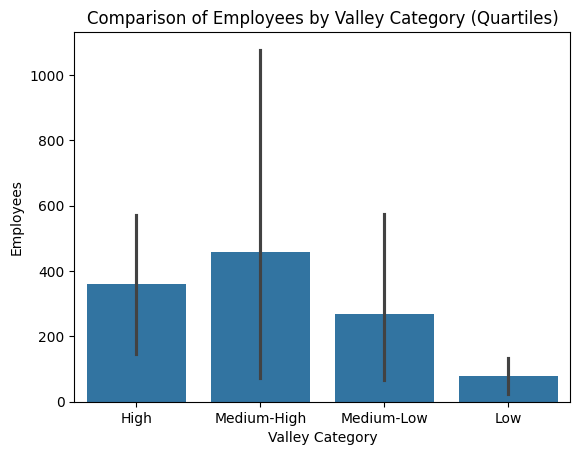

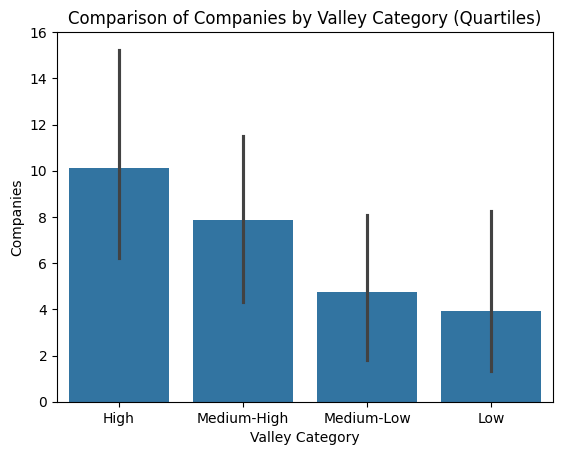

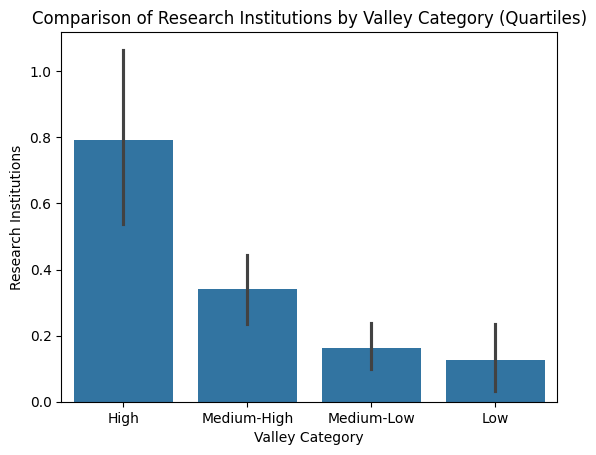

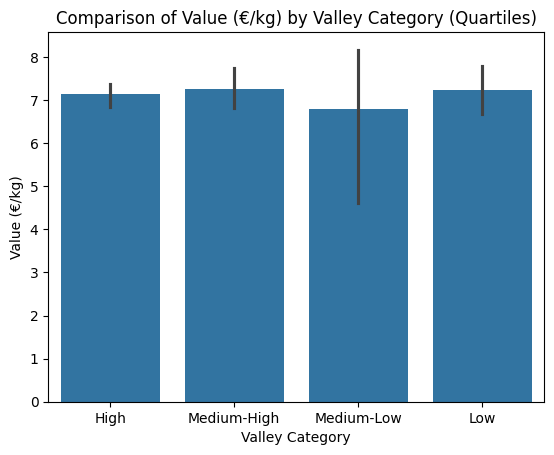

In [6]:
# Ensure the categories are ordered from 'High' to 'Low'
category_order = ['High', 'Medium-High', 'Medium-Low', 'Low']

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar plot for each value chain component by quartile category
for column in ['Output T/year', 'Consumption T/year', 'Hydrogen Stations', 'FCEV Fleet', 'Employees', 'Companies', 'Research Institutions', 'Value (€/kg)']:
    sns.barplot(x='Valley Category', y=column, data=data, order=category_order)
    plt.title(f'Comparison of {column} by Valley Category (Quartiles)')
    plt.ylabel(column)
    plt.xlabel('Valley Category')
    plt.show()

Checkin to see whether to use ANOVA or KW-Test

In [7]:
# Check normality
for column in ['Output T/year', 'Consumption T/year', 'Hydrogen Stations', 'FCEV Fleet', 'Employees', 'Companies', 'Research Institutions', 'Value (€/kg)']:
    stat, p = stats.shapiro(data[column])
    print(f'{column} - Shapiro-Wilk Test: p-value = {p}')

# Check homogeneity of variances
for column in ['Output T/year', 'Consumption T/year', 'Hydrogen Stations', 'FCEV Fleet', 'Employees', 'Companies', 'Research Institutions', 'Value (€/kg)']:
    stat, p = stats.levene(*[data[data['Valley Category'] == cat][column].dropna() for cat in ['Low', 'Medium-Low', 'Medium-High', 'High']])
    print(f'{column} - Levene’s Test: p-value = {p}')

Output T/year - Shapiro-Wilk Test: p-value = 0.0015608918319365615
Consumption T/year - Shapiro-Wilk Test: p-value = 0.0013439105108737704
Hydrogen Stations - Shapiro-Wilk Test: p-value = 0.00020130707646587247
FCEV Fleet - Shapiro-Wilk Test: p-value = 2.0229755320042504e-07
Employees - Shapiro-Wilk Test: p-value = 1.200372645569524e-07
Companies - Shapiro-Wilk Test: p-value = 0.0005144180400020637
Research Institutions - Shapiro-Wilk Test: p-value = 0.00043020807687191894
Value (€/kg) - Shapiro-Wilk Test: p-value = 1.6035159592662413e-07
Output T/year - Levene’s Test: p-value = 0.392016004397533
Consumption T/year - Levene’s Test: p-value = 0.39351878314392674
Hydrogen Stations - Levene’s Test: p-value = 0.9765736584146427
FCEV Fleet - Levene’s Test: p-value = 0.06935884961253092
Employees - Levene’s Test: p-value = 0.5016653861825329
Companies - Levene’s Test: p-value = 0.9164403734820551
Research Institutions - Levene’s Test: p-value = 0.03090600351213171
Value (€/kg) - Levene’s Tes

Conduct the test KW

In [8]:
# Perform Kruskal-Wallis test for each value chain component
quartile_kruskal_results = {}
for column in ['Output T/year', 'Consumption T/year', 'Hydrogen Stations', 'FCEV Fleet', 'Employees', 'Companies', 'Research Institutions', 'Value (€/kg)']:
    groups = [data[data['Valley Category'] == cat][column].dropna() for cat in category_order]
    quartile_kruskal_results[column] = kruskal(*groups)

quartile_kruskal_results

{'Output T/year': KruskalResult(statistic=2.9598756506651207, pvalue=0.3978530237483451),
 'Consumption T/year': KruskalResult(statistic=2.962426496022138, pvalue=0.3974546243264667),
 'Hydrogen Stations': KruskalResult(statistic=1.2246835443037989, pvalue=0.7470904687559861),
 'FCEV Fleet': KruskalResult(statistic=3.208140920601794, pvalue=0.36063369649801097),
 'Employees': KruskalResult(statistic=3.8055234239444604, pvalue=0.2832443172676874),
 'Companies': KruskalResult(statistic=7.629526402212416, pvalue=0.05432211985624777),
 'Research Institutions': KruskalResult(statistic=18.724458874458875, pvalue=0.00031170940015312436),
 'Value (€/kg)': KruskalResult(statistic=0.20456509216589325, pvalue=0.9768489929318436)}

In [9]:
import scikit_posthocs as sp

# Extract the relevant data for the Research Institutions variable
research_data = data[['Valley Category', 'Research Institutions']]

# Perform Dunn's test for pairwise comparisons
posthoc_results = sp.posthoc_dunn(research_data, val_col='Research Institutions', group_col='Valley Category', p_adjust='bonferroni')

# Ensure the results are ordered from 'High' to 'Low' in both rows and columns
category_order = ['High', 'Medium-High', 'Medium-Low', 'Low']
posthoc_results = posthoc_results.loc[category_order, category_order]

# Display the posthoc results
posthoc_results

,High,Medium-High,Medium-Low,Low
High,1.000000,0.452635,0.003484,0.000557
Medium-High,0.452635,1.000000,0.732533,0.274229
Medium-Low,0.003484,0.732533,1.000000,1.000000
Low,0.000557,0.274229,1.000000,1.000000


# Older artifacts
Below are other analysis that I conducted during the course of this master thesis that did not make it into the final document but could still be useful for other considerations.

## Corelation analysis

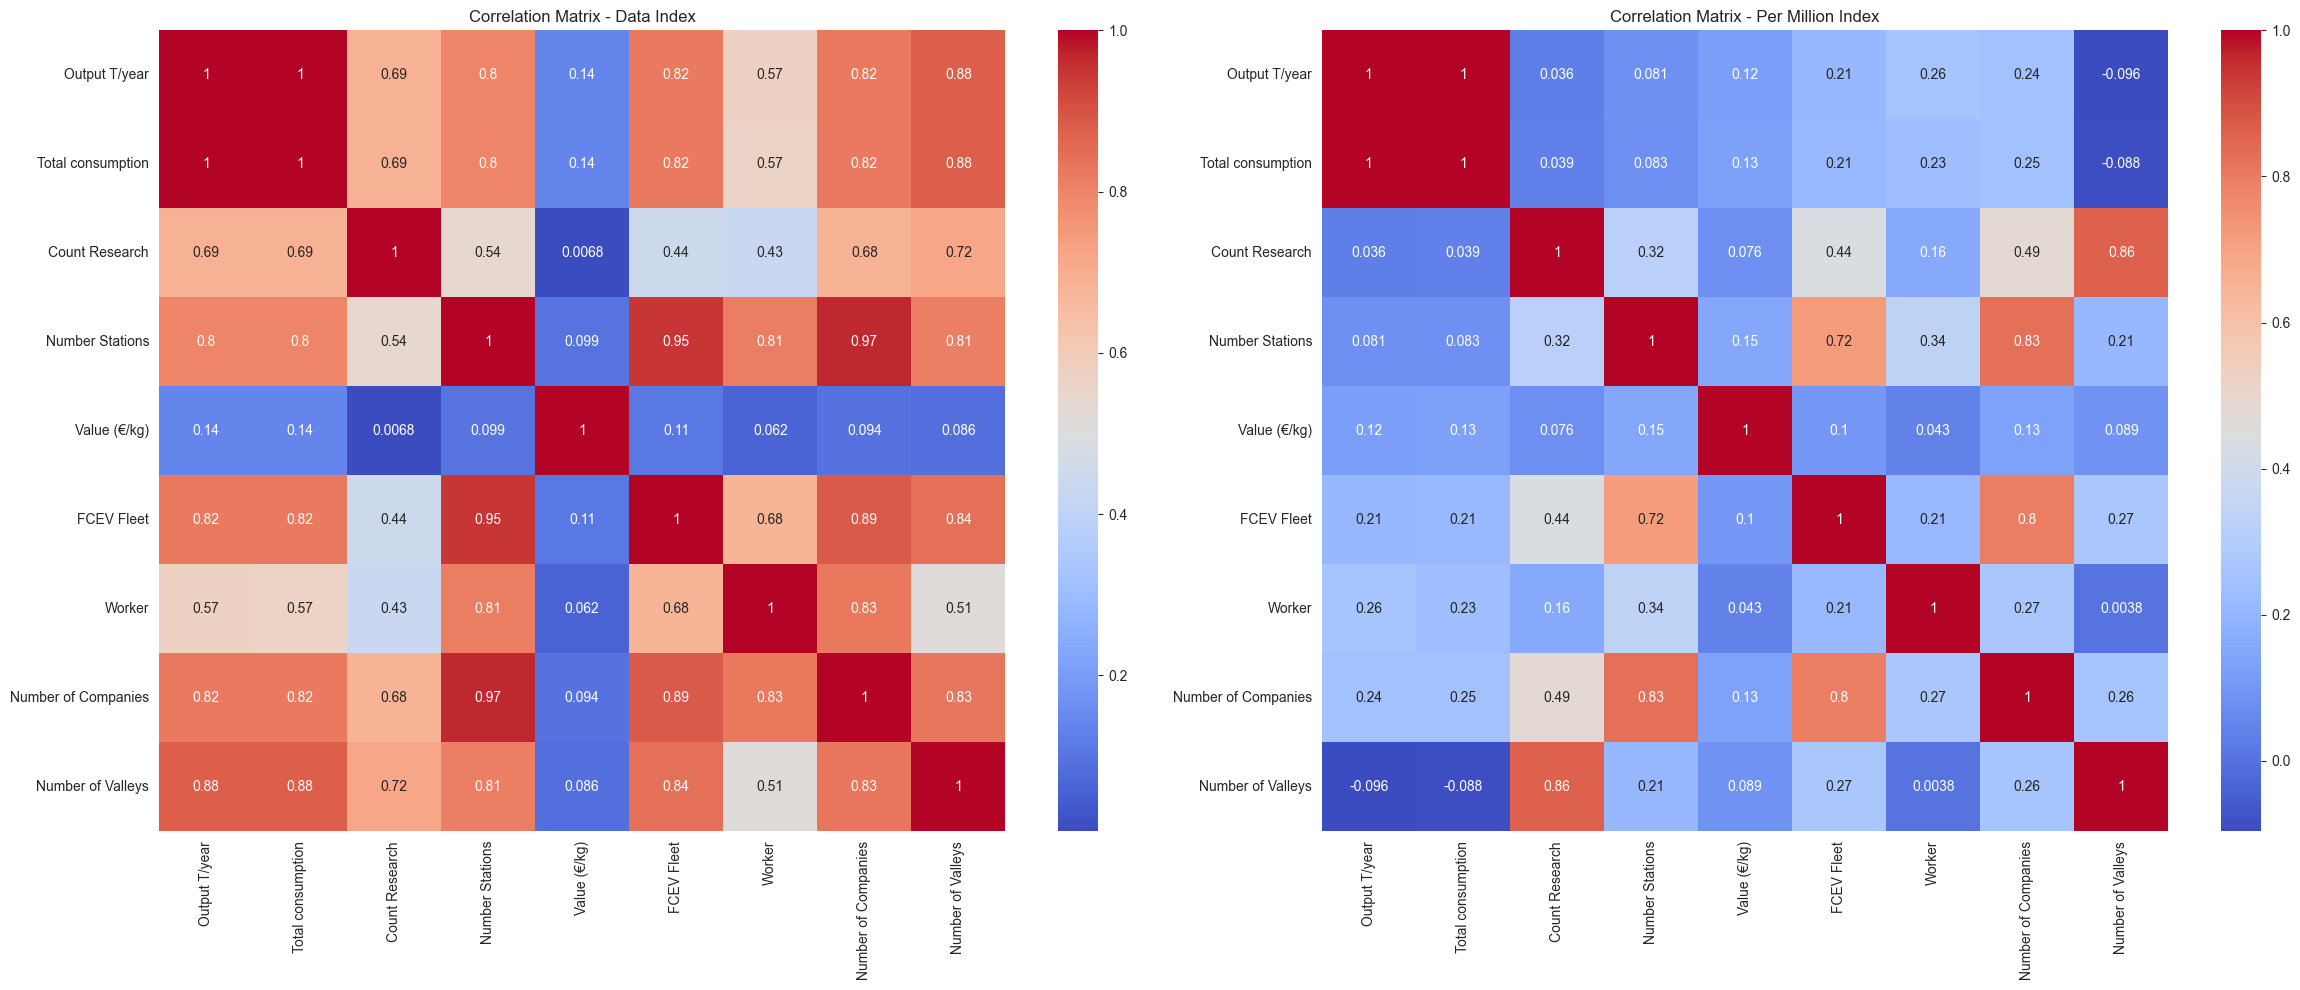

In [70]:
# Exclude non-numeric columns from correlation calculation
numeric_columns = merged_df.select_dtypes(include=np.number).columns
correlation_matrix_data_index = merged_df[numeric_columns].corr()
correlation_matrix_per_million_index = per_million_df[numeric_columns].corr()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot the first heatmap
sns.heatmap(correlation_matrix_data_index, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix - Data Index')

# Plot the second heatmap
sns.heatmap(correlation_matrix_per_million_index, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix - Per Million Index')

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('correlation_matrices.png')

# Display the figure
plt.show()

# Scatter plots

Here we create different combinations of dimensions to try and find noteworthy plots for the master thesis.

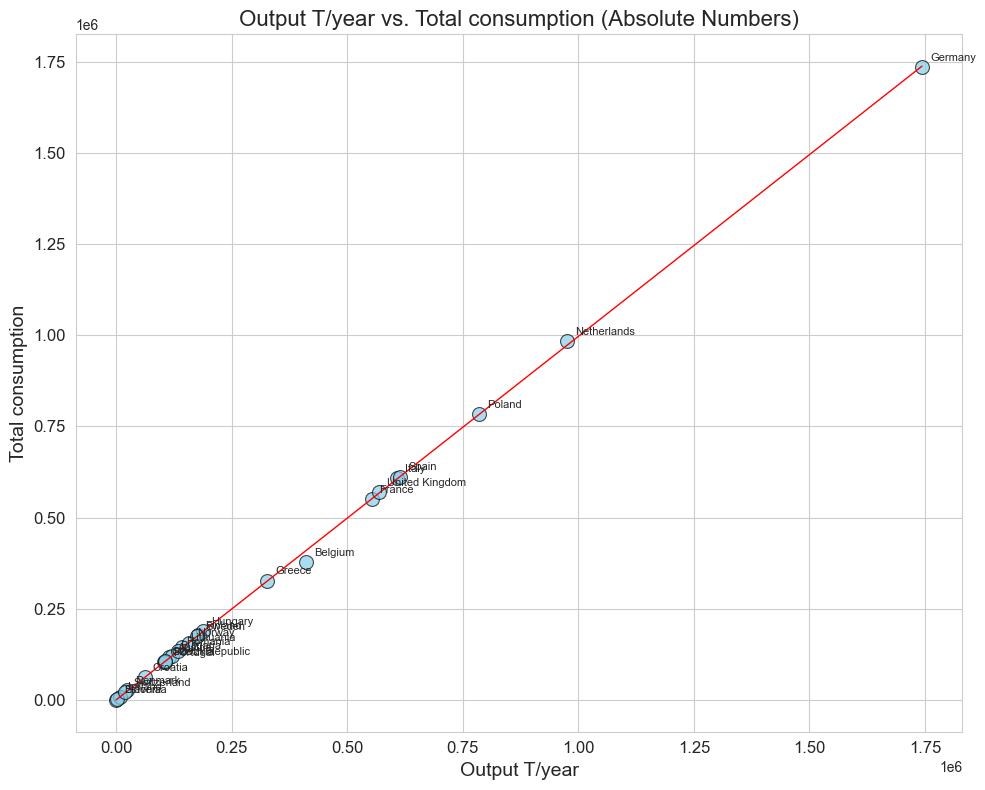

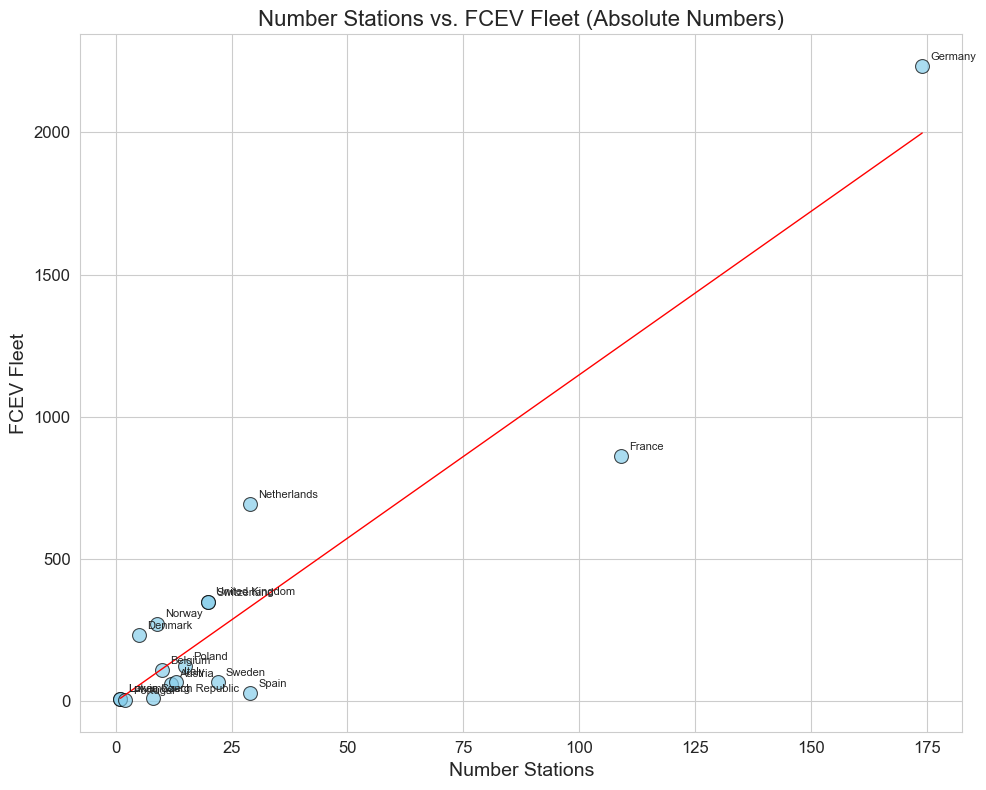

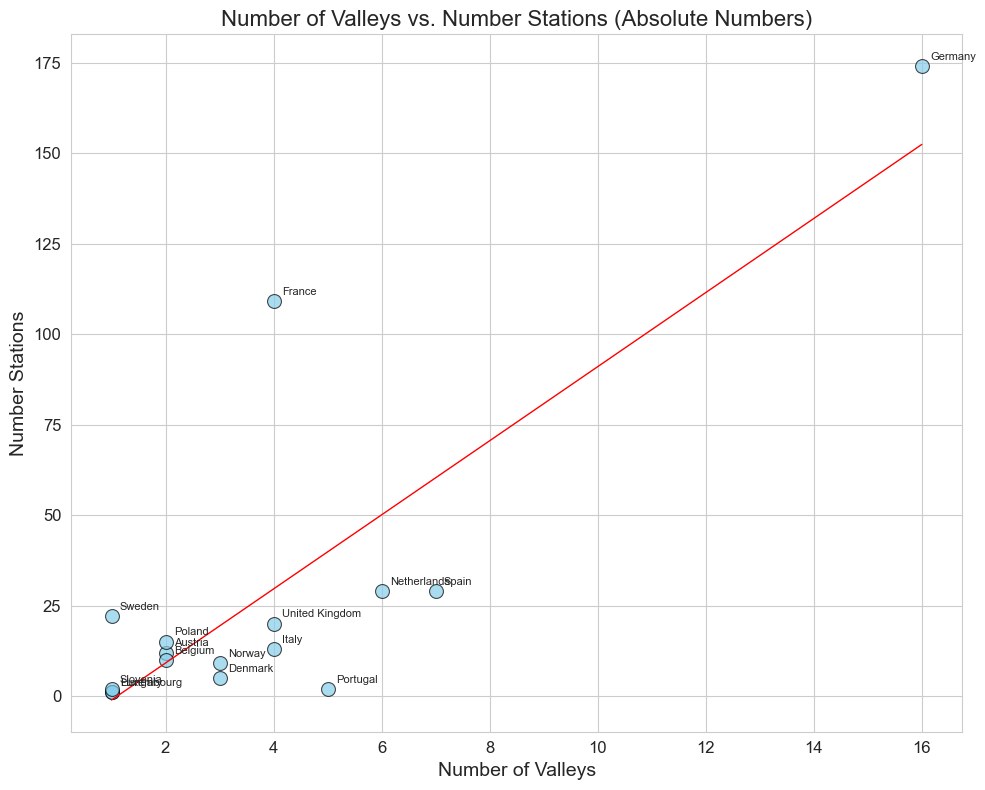

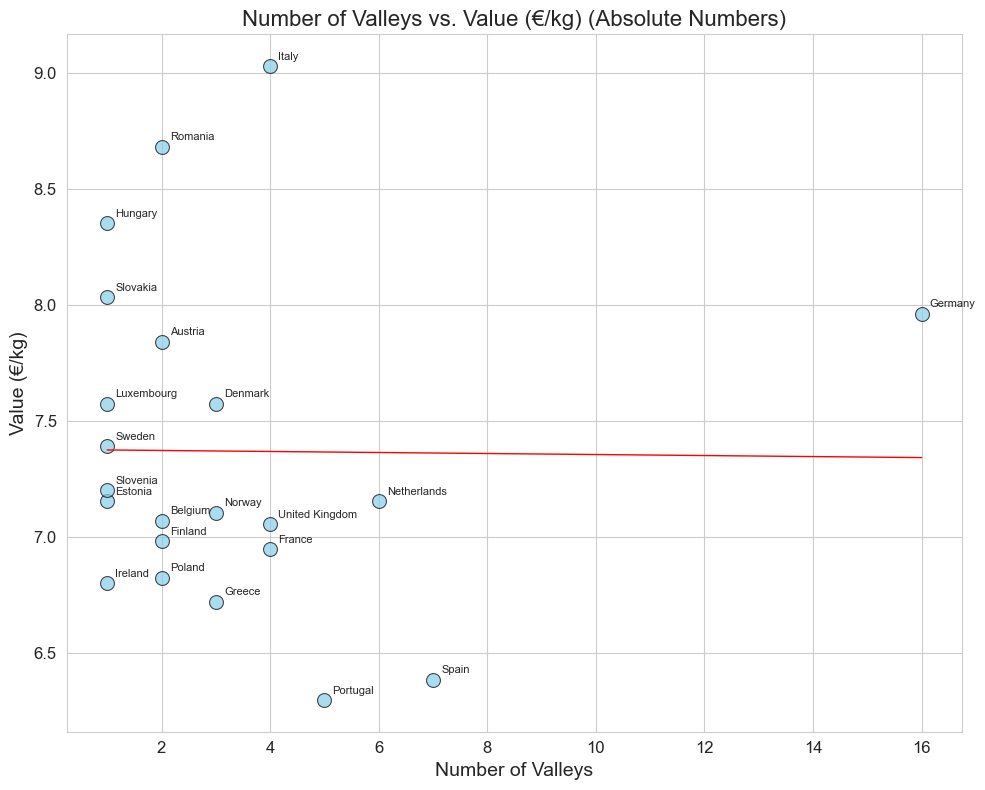

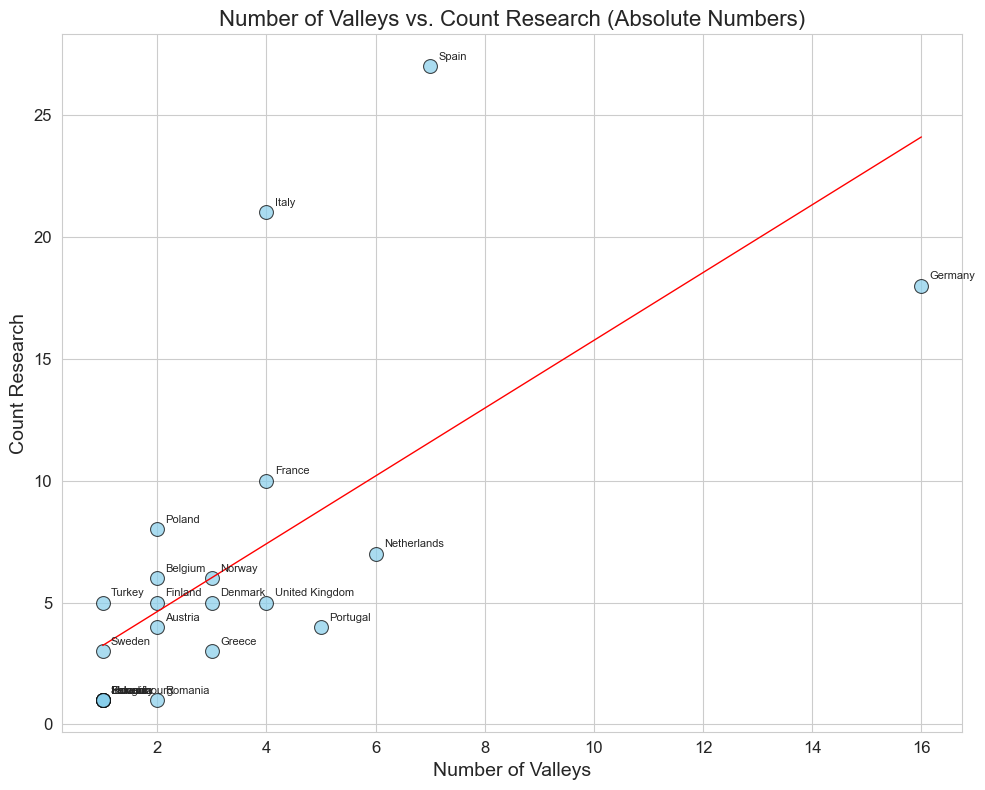

KeyError: 'Number of Patents'

In [71]:
def create_correlation_plots(dataframe, var_pairs, title_suffix=""):
    for x_var, y_var in var_pairs:
        # Filter out rows with zero values in either x_var or y_var
        filtered_df = dataframe[(dataframe[x_var] != 0.0) & (dataframe[y_var] != 0.0)]

        plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")  # Set the style
        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black')  # Adjust marker size and color
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1})  # Adjust regression line

        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for i in range(len(filtered_df)):
            plt.text(filtered_df[x_var].iloc[i] + x_offset, filtered_df[y_var].iloc[i] + y_offset, filtered_df['Country'].iloc[i], fontsize=8)  # Adjust label font size

        plt.title(f'{x_var} vs. {y_var} {title_suffix}', fontsize=16)  # Adjust title font size
        plt.xlabel(x_var, fontsize=14)  # Adjust x-axis label font size
        plt.ylabel(y_var, fontsize=14)  # Adjust y-axis label font size
        plt.xticks(fontsize=12)  # Adjust tick label font size
        plt.yticks(fontsize=12)  # Adjust tick label font size
        plt.tight_layout()  # Adjust layout
        plt.show()

# Variable pairs for absolute analysis
absolute_pairs = [
    ('Output T/year', 'Total consumption'), #interesting
    ('Number Stations', 'FCEV Fleet'), #obvious buy maybe good to show for the report
    ('Number of Valleys', 'Number Stations'), #interesting
    ('Number of Valleys', 'Value (€/kg)'), #interesting
    ('Number of Valleys', 'Count Research'), #interesting
    ('Number of Patents', 'Count Research'), #interesting
]

# Variable pairs for per million analysis
per_million_pairs = [
    ('Number of Patents', 'Count Research'),
    ('Number of Valleys', 'FCEV Fleet'), #interesting
    ('Number of Valleys', 'Total consumption'), #interesting
    ('Number of Valleys', 'Worker'), #interesting
    ('Value (€/kg)', 'Output T/year'), #interesting
]

# Create plots for absolute numbers
create_correlation_plots(merged_df, absolute_pairs, title_suffix="(Absolute Numbers)")

# Create plots for per million numbers
create_correlation_plots(per_million_df, per_million_pairs, title_suffix="(Per Million)")


Combinations that were found interesting were put together for a closer analysis. Fitting graphs were combined into one picture to save space in the master thesis.

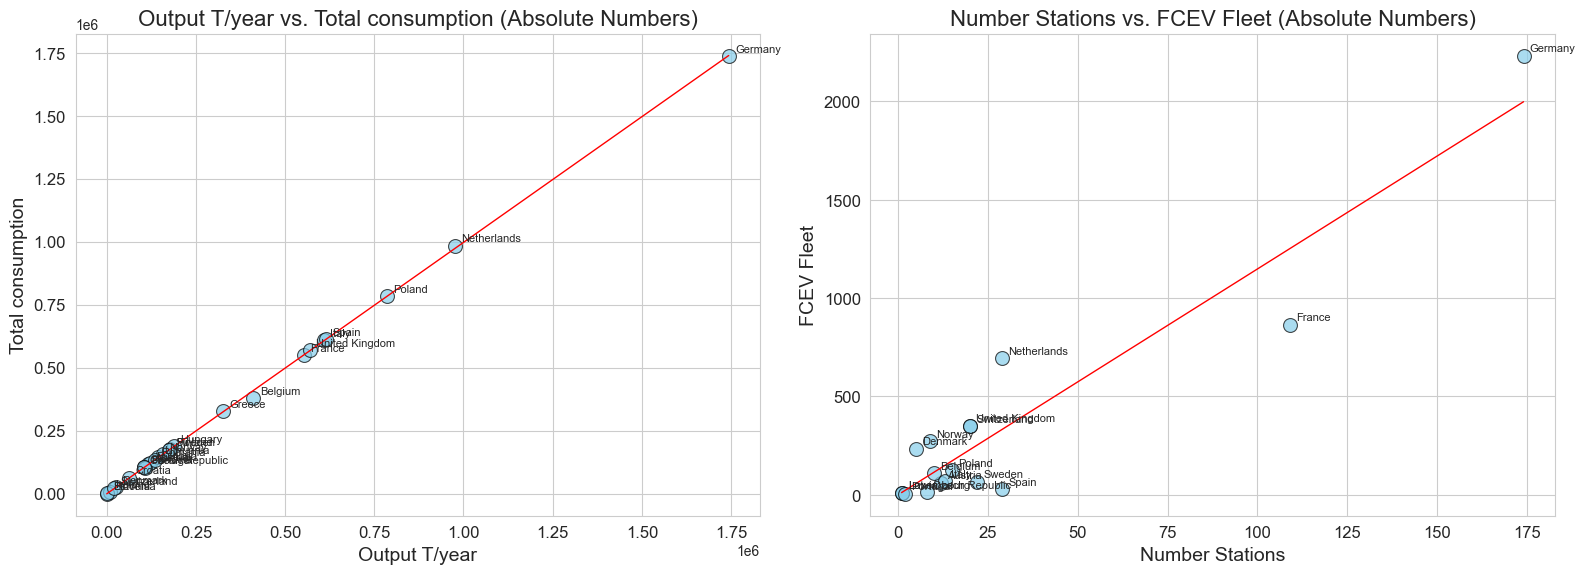

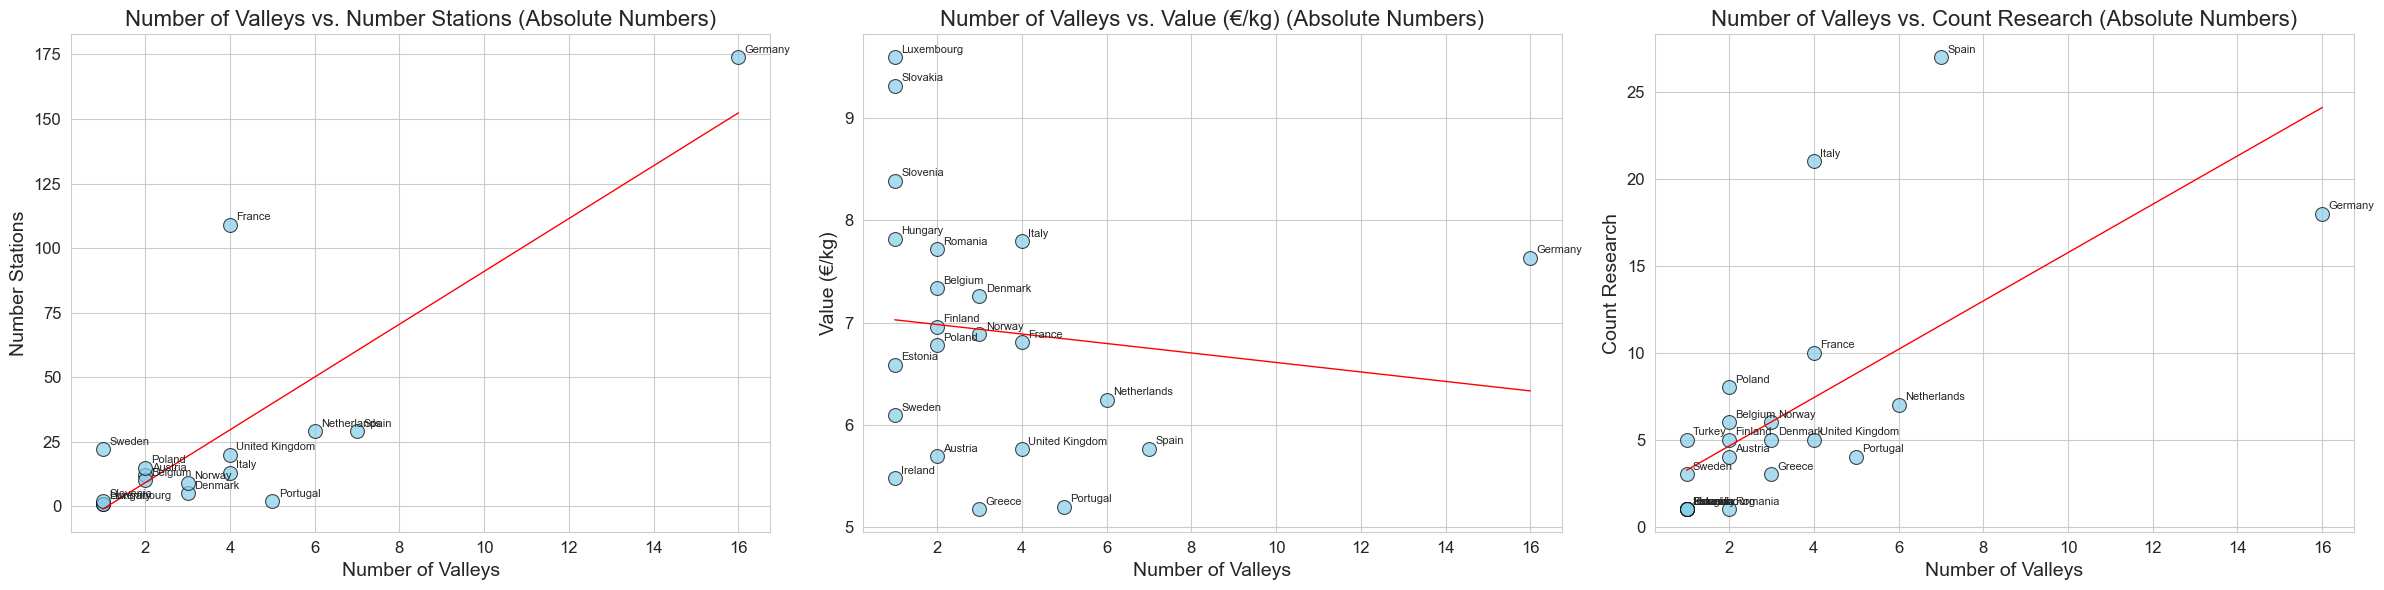

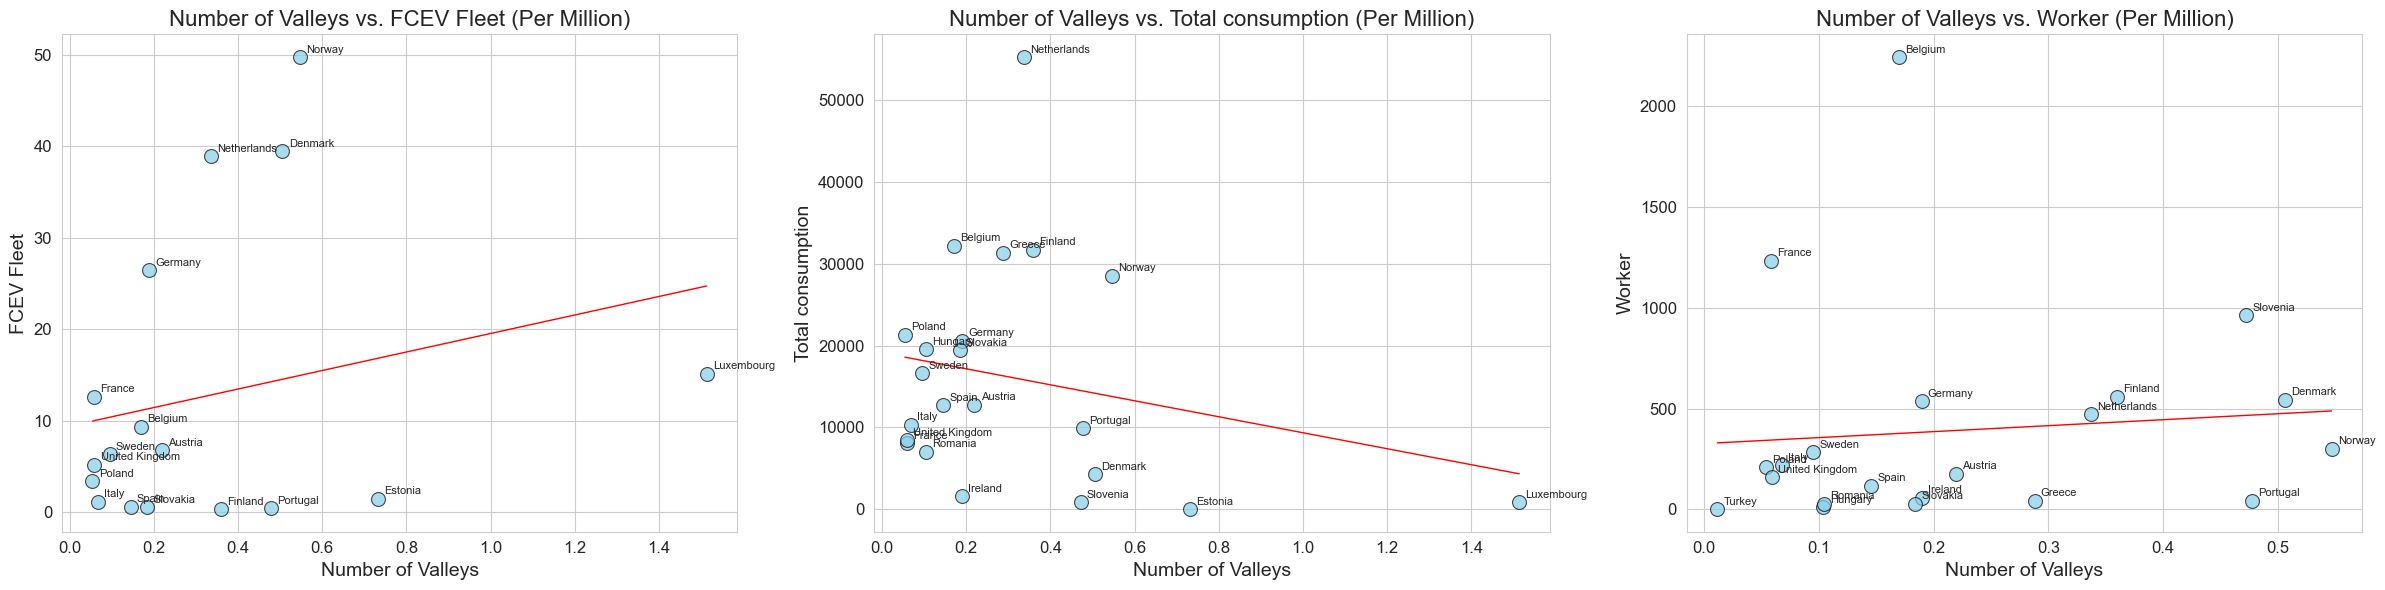

In [ ]:
# Define plot combinations
plot_combinations = [
    # Absolute values
    [
        ('Output T/year', 'Total consumption'),
        ('Number Stations', 'FCEV Fleet')
    ],
    [
        ('Number of Valleys', 'Number Stations'),
        ('Number of Valleys', 'Value (€/kg)'),
        ('Number of Valleys', 'Count Research')
    ],
    # Absolute and per million
    [
        ('Number of Patents', 'Count Research'),
        ('Number of Patents', 'Count Research')
    ],
    # Per million values
    [
        ('Number of Valleys', 'FCEV Fleet'),
        ('Number of Valleys', 'Total consumption'),
        ('Number of Valleys', 'Worker')
    ]
]

# Define a function to create and save plots
def create_and_save_plots(dataframe, var_pairs, title_suffix, file_name):
    num_plots = len(var_pairs)
    fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))
    axes = np.atleast_1d(axes)  # Ensure axes is always an array

    for i, (x_var, y_var) in enumerate(var_pairs):
        filtered_df = dataframe[(dataframe[x_var] != 0.0) & (dataframe[y_var] != 0.0)]

        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i])

        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i].set_title(f'{x_var} vs. {y_var} {title_suffix}', fontsize=16)
        axes[i].set_xlabel(x_var, fontsize=14)
        axes[i].set_ylabel(y_var, fontsize=14)
        axes[i].tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Create plots for absolute numbers - Group 1
create_and_save_plots(merged_df, plot_combinations[0], '(Absolute Numbers)', 'combined_plots_group1.png')

# Create plots for absolute numbers - Group 2
create_and_save_plots(merged_df, plot_combinations[1], '(Absolute Numbers)', 'combined_plots_group2.png')

# Create plots for per million numbers - Group 4
create_and_save_plots(per_million_df, plot_combinations[3], '(Per Million)', 'combined_plots_group4.png')

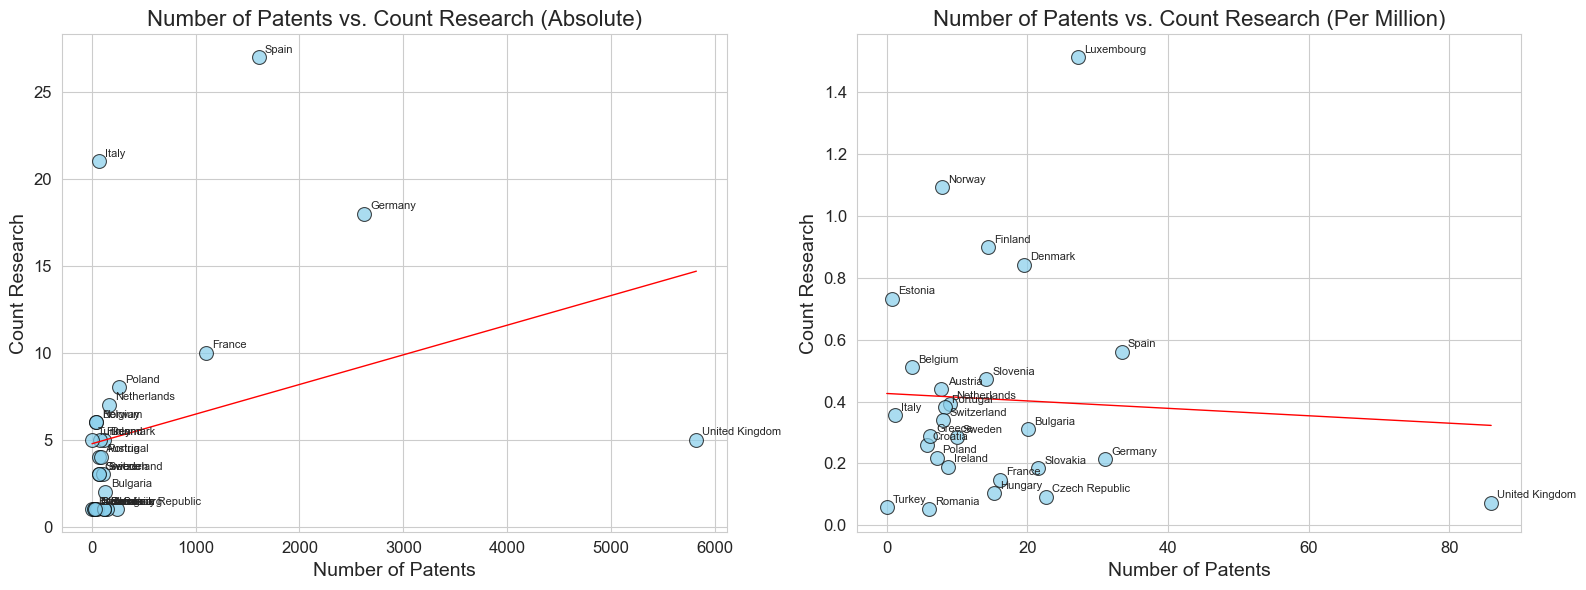

In [ ]:
# Define a function to create and save combined plots for absolute and per million values
def create_combined_plots(data_abs, data_per_million, var_pairs_abs, var_pairs_per_million, title_suffix, file_name):
    num_plots = len(var_pairs_abs) + len(var_pairs_per_million)
    fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))
    axes = np.atleast_1d(axes)  # Ensure axes is always an array

    for i, (x_var, y_var) in enumerate(var_pairs_abs):
        filtered_df = data_abs[(data_abs[x_var] != 0.0) & (data_abs[y_var] != 0.0)]

        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i])

        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i].set_title(f'{x_var} vs. {y_var} (Absolute)', fontsize=16)
        axes[i].set_xlabel(x_var, fontsize=14)
        axes[i].set_ylabel(y_var, fontsize=14)
        axes[i].tick_params(axis='both', labelsize=12)

    for i, (x_var, y_var) in enumerate(var_pairs_per_million):
        filtered_df = data_per_million[(data_per_million[x_var] != 0.0) & (data_per_million[y_var] != 0.0)]

        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i + len(var_pairs_abs)])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i + len(var_pairs_abs)])

        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i + len(var_pairs_abs)].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i + len(var_pairs_abs)].set_title(f'{x_var} vs. {y_var} (Per Million)', fontsize=16)
        axes[i + len(var_pairs_abs)].set_xlabel(x_var, fontsize=14)
        axes[i + len(var_pairs_abs)].set_ylabel(y_var, fontsize=14)
        axes[i + len(var_pairs_abs)].tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Create combined plots for Group 3
create_combined_plots(merged_df, per_million_df, [plot_combinations[2][0]], [plot_combinations[2][1]], '(Absolute and Per Million)', 'combined_plots_group3.png')

Since we also included indexes, thos were also used for analysis and included. More specifically:

- Carbon intensity is a measure of carbon dioxide and other greenhouse gases (CO2e) per unit of activity, like generating a product.

- The IMD World Competitiveness Ranking was created, in a bid to provide actionable data analysis on economies, regions and sub-regions according to how they optimize their individual competencies in order to achieve long-term value creation for their people. It provides benchmarking and exposes trends, using both statistics and real-world survey data.

- Share of energy consumption from renewable sources in Europe

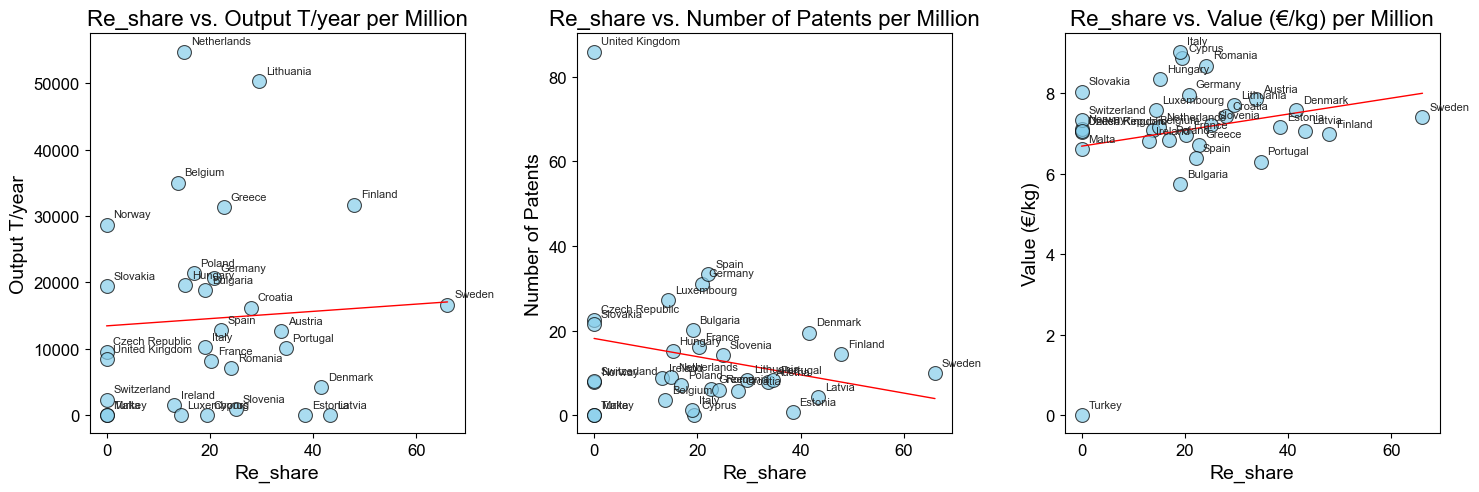

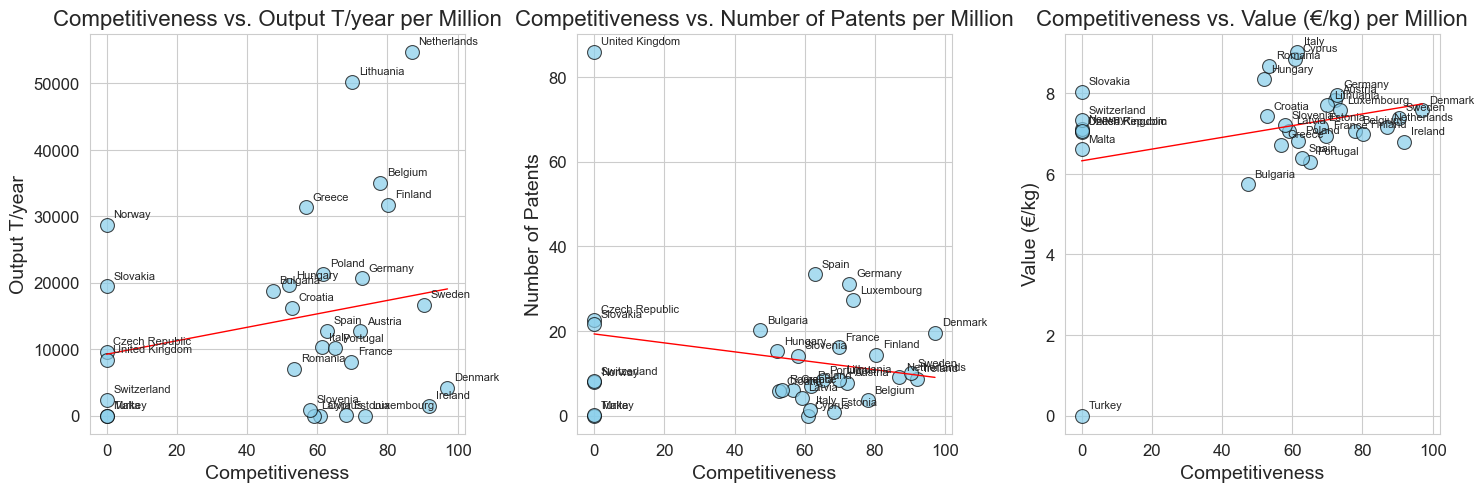

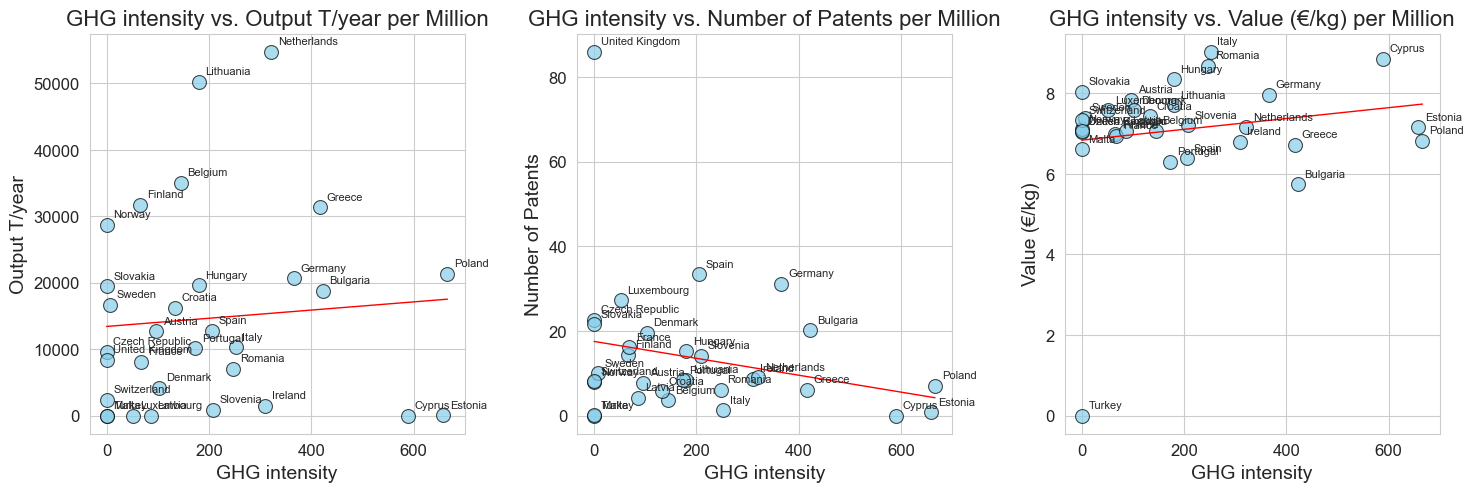

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_index_comparison_plots(dataframe, indices, variables, title_suffix=""):
    for index in indices:
        num_vars = len(variables)
        fig, axes = plt.subplots(1, num_vars, figsize=(5 * num_vars, 5))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array

        for col, var in enumerate(variables):
            ax = axes[col]
            sns.set_style("whitegrid")
            sns.scatterplot(x=index, y=var, data=dataframe, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=ax)
            sns.regplot(x=index, y=var, data=dataframe, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=ax)

            x_range = dataframe[index].max() - dataframe[index].min()
            y_range = dataframe[var].max() - dataframe[var].min()
            x_offset = x_range * 0.02
            y_offset = y_range * 0.02

            for i in range(len(dataframe)):
                ax.text(dataframe[index].iloc[i] + x_offset, dataframe[var].iloc[i] + y_offset, dataframe['Country'].iloc[i], fontsize=8)

            ax.set_title(f'{index} vs. {var} {title_suffix}', fontsize=16)
            ax.set_xlabel(index, fontsize=14)
            ax.set_ylabel(var, fontsize=14)
            ax.tick_params(axis='both', labelsize=12)

        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.05, right=0.95, hspace=0.3, wspace=0.3)  # Adjust layout to add space between plots
        plt.savefig(f'{index}_comparison_{title_suffix.replace(" ", "_")}.png')
        plt.show()

# Define indices and hydrogen economy variables
indices = ['Re_share', 'Competitiveness', 'GHG intensity']
hydrogen_variables = ['Output T/year', 'Number of Patents', 'Value (€/kg)']

# Create scatter plots with regression lines
create_index_comparison_plots(per_million_df_index, indices, hydrogen_variables, title_suffix="per Million")


### 8. Value Chain Analysis

In this step, the analysis focuses on understanding the distribution and normalization of various aspects of the hydrogen value chain across different countries. Here's a detailed explanation of what happens:

#### Relative Distribution Calculation

1. **Define Value Chain Steps**:
   - A dictionary is created to map different steps in the hydrogen value chain to their corresponding columns in the dataset. These steps include production, costs, demand, research, patents, charging infrastructure, usage (FCEV fleet), and companies.

2. **Calculate Relative Distribution**:
   - For each step in the value chain, the sum of the relevant columns is calculated for each country. This sum is then divided by the total sum across all countries to get the relative distribution.
   - The relative distribution values represent each country's contribution to a particular value chain step relative to the total contribution of all countries.

3. **Create DataFrame for Relative Distribution**:
   - The calculated relative distributions are stored in a DataFrame with countries as rows and value chain steps as columns.
   - An additional column is calculated to store the sum of each row, which represents the total relative contribution of each country across all value chain steps.

4. **Sort and Visualize**:
   - The DataFrame is sorted based on the total relative contribution (row sum) in descending order.
   - A heatmap is plotted to visualize the relative distribution of each country in the hydrogen value chain. The rows (countries) are sorted by their overall relative value, and the color intensity in the heatmap represents the relative contribution.


In [73]:
# Step 3: Value Chain Analysis
value_chain_steps = {
    'Production': ['Output T/year'],
    'Production Cost': ['Value (€/kg)'],
    'Demand': ['Total consumption'],
    'Research Institutions': ['Count Research'],
    'Charging Infrastructure': ['Number Stations'],
    'Usage ': ['FCEV Fleet'],
    'Companies': ['Number of Companies']
}

relative_distribution = {}

for step, columns in value_chain_steps.items():
    relative_distribution[step] = merged_df[columns].sum(axis=1) / merged_df[columns].sum(axis=1).sum()
    print(f'{step}: {relative_distribution[step]}')


Production: 0     0.014029
1     0.049962
2     0.014722
3     0.007571
4     0.000000
5     0.012619
6     0.003032
7     0.000002
8     0.021436
9     0.067164
10    0.211825
11    0.039675
12    0.022841
13    0.000955
14    0.073857
15    0.000000
16    0.017457
17    0.000000
18    0.000000
19    0.118485
20    0.019149
21    0.095328
22    0.012913
23    0.016321
24    0.012829
25    0.000224
26    0.074654
27    0.021306
28    0.002497
29    0.000000
30    0.069146
dtype: float64
Production Cost: 0     0.035654
1     0.032151
2     0.026124
3     0.033789
4     0.040281
5     0.032033
6     0.034440
7     0.032528
8     0.031745
9     0.031588
10    0.036200
11    0.030566
12    0.037971
13    0.030930
14    0.041049
15    0.032117
16    0.035023
17    0.034438
18    0.030041
19    0.032536
20    0.032304
21    0.031033
22    0.028638
23    0.039474
24    0.036531
25    0.032752
26    0.029034
27    0.033614
28    0.033333
29    0.000000
30    0.032082
dtype: float64
Demand: 0  

In [74]:
relative_distribution = pd.DataFrame(relative_distribution)
relative_distribution.index = merged_df['Country']
relative_distribution

relative_distribution.sum(axis=0)

Production                 1.0
Production Cost            1.0
Demand                     1.0
Research Institutions      1.0
Charging Infrastructure    1.0
Usage                      1.0
Companies                  1.0
dtype: float64

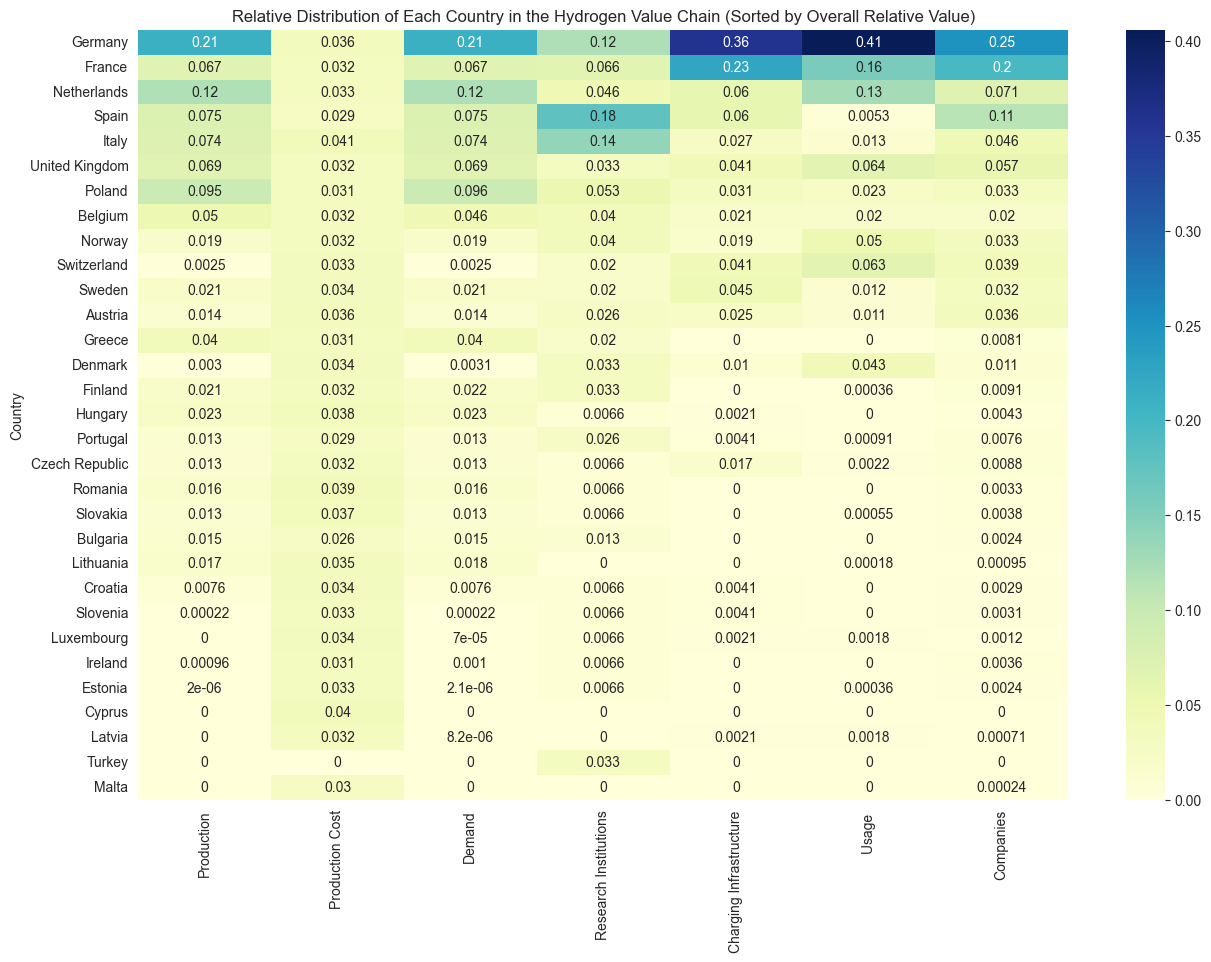

In [75]:
# Calculate the sum of each row
relative_distribution['row_sum'] = relative_distribution.sum(axis=1)

# Sort the DataFrame based on the row sum in descending order
relative_distribution_sorted = relative_distribution.sort_values(by='row_sum', ascending=False).drop(columns='row_sum')

# Plotting heatmap with sorted rows and rotated y-axis tick labels
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(relative_distribution_sorted, cmap='YlGnBu', annot=True, ax=ax)
ax.set_title('Relative Distribution of Each Country in the Hydrogen Value Chain (Sorted by Overall Relative Value)')
plt.yticks(rotation=0)  # Rotate y-axis tick labels to be horizontal
plt.show()

In [76]:
#give plot as png
fig.savefig('relative_distribution.png')

However, as we're dealing with different populations and country sizes a per million perspective would be better suited. And to make it readable, we normalize it from 0 to 1.

#### Normalized Distribution Calculation

1. **Normalize Values**:
   - For each value chain step, the values are normalized to a scale of 0 to 1. Normalization is done by subtracting the minimum value and dividing by the range (maximum value - minimum value).
   - For the cost step, the normalized values are inverted (1 - normalized value) because lower costs are more favorable.

2. **Create DataFrame for Normalized Distribution**:
   - The normalized values are stored in a DataFrame with countries as rows and value chain steps as columns.
   - An additional column is added to store the sum of each row, representing the total normalized contribution of each country across all value chain steps.

3. **Sort and Visualize**:
   - The DataFrame is sorted based on the total normalized contribution (row sum) in descending order.
   - A heatmap is plotted to visualize the normalized distribution of each country in the hydrogen value chain. The rows are sorted by their overall normalized value, and the color intensity in the heatmap represents the normalized contribution.

Production T/year: 0     0.231630
1     0.639587
2     0.343232
3     0.295550
4     0.000000
5     0.175199
6     0.076817
7     0.000225
8     0.579147
9     0.148102
10    0.377469
11    0.572703
12    0.357682
13    0.027247
14    0.188190
15    0.000000
16    0.918441
17    0.000000
18    0.000000
19    1.000000
20    0.524418
21    0.389901
22    0.185447
23    0.128759
24    0.355253
25    0.015930
26    0.233386
27    0.304407
28    0.042575
29    0.000000
30    0.153454
dtype: float64
Costs (€/kg): 0     0.361509
1     0.596192
2     1.000000
3     0.486463
4     0.051443
5     0.604093
6     0.442842
7     0.570909
8     0.623420
9     0.633935
10    0.324867
11    0.702413
12    0.206199
13    0.677989
14    0.000000
15    0.598456
16    0.403787
17    0.442981
18    0.737541
19    0.570406
20    0.585930
21    0.671106
22    0.831539
23    0.105500
24    0.302688
25    0.555907
26    0.805018
27    0.498139
28    0.516969
29    0.589016
30    0.600834
dtype: float64
Demand 

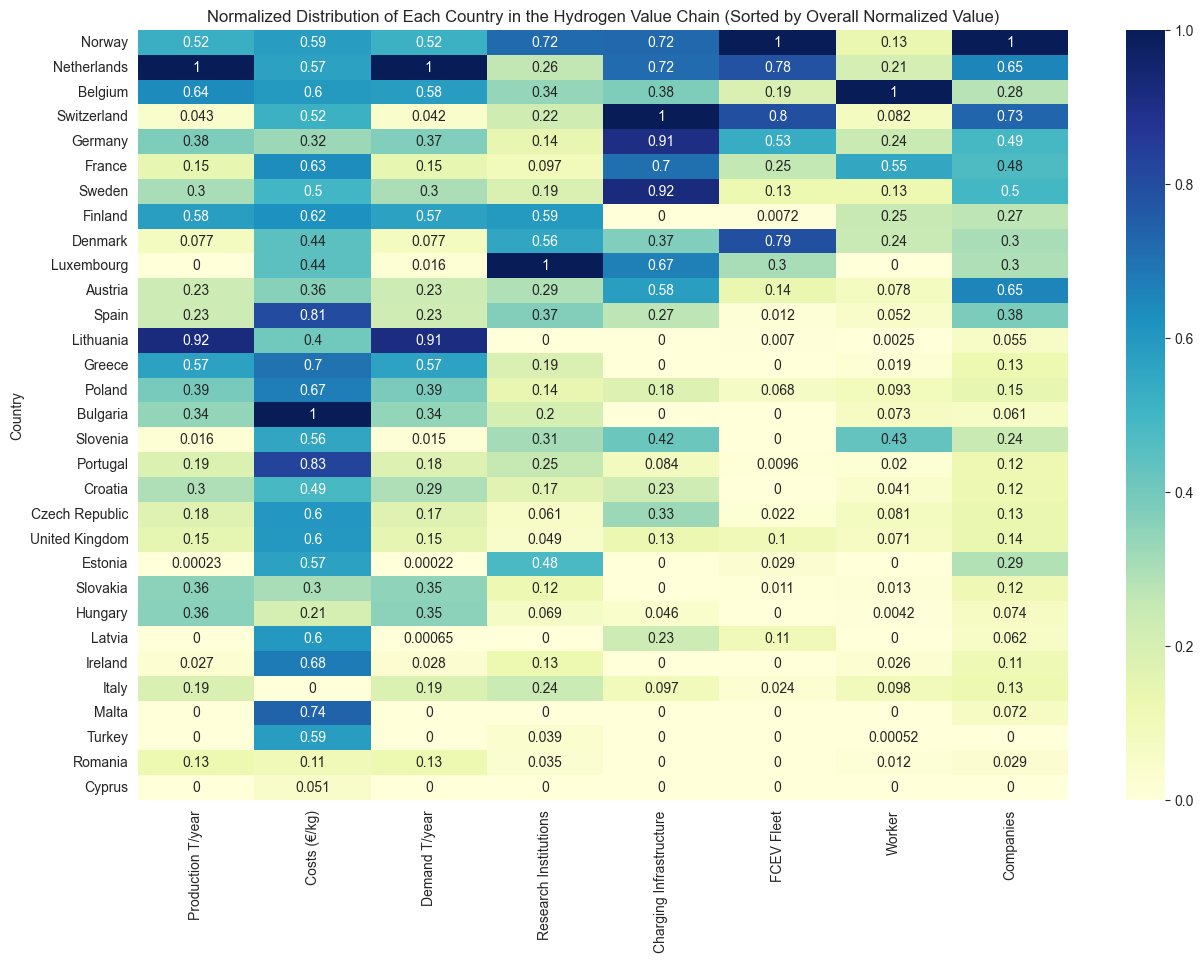

In [77]:
# Step 3: Value Chain Analysis
value_chain_steps = {
    'Production T/year': ['Output T/year'],
    'Costs (€/kg)': ['Value (€/kg)'],
    'Demand T/year': ['Total consumption'],
    'Research Institutions': ['Count Research'],
    'Charging Infrastructure': ['Number Stations'],
    'FCEV Fleet': ['FCEV Fleet'],
    'Worker': ['Worker'],
    'Companies': ['Number of Companies']
}

# Normalize the values for each step
normalized_values = {}

# No data was avilable for turkey in the value per kg column, so we will replace it with the mean value
mean_value_eur_kg = per_million_df['Value (€/kg)'].mean()
per_million_df.loc[per_million_df['Country'] == 'Turkey', 'Value (€/kg)'] = mean_value_eur_kg

for step, columns in value_chain_steps.items():
    step_data = per_million_df[columns].sum(axis=1)
    normalized_values[step] = (step_data - step_data.min()) / (step_data.max() - step_data.min())
    if step == 'Costs (€/kg)':
        normalized_values[step] = 1 - normalized_values[step]  # Invert the normalized values for costs
    print(f'{step}: {normalized_values[step]}')

# Create a DataFrame from the normalized values
normalized_distribution = pd.DataFrame(normalized_values)
normalized_distribution.index = per_million_df['Country']  # Ensure the index is from the original per_million_df

# Calculate the sum of each row for sorting purposes
normalized_distribution['row_sum'] = normalized_distribution.sum(axis=1)

# Sort the DataFrame based on the row sum in descending order
normalized_distribution_sorted = normalized_distribution.sort_values(by='row_sum', ascending=False).drop(columns='row_sum')

# Plotting heatmap with sorted rows and rotated y-axis tick labels
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(normalized_distribution_sorted, cmap='YlGnBu', annot=True, ax=ax)
ax.set_title('Normalized Distribution of Each Country in the Hydrogen Value Chain (Sorted by Overall Normalized Value)')
plt.yticks(rotation=0)  # Rotate y-axis tick labels to be horizontal
plt.show()

fig.savefig('normalized_per_million.png')

In [78]:
per_million_df

,Output T/year,Total consumption,Number Stations,FCEV Fleet,Worker,Number of Companies,Number of Valleys,Count Research,Value (€/kg),Country
0,12682.617893,12753.204588,1.317990,6.809616,175.622190,16.694542,0.219665,0.439330,7.842083,Austria
1,35019.737601,32204.006858,0.851586,9.367445,2243.247690,7.153322,0.170317,0.510952,7.071683,Belgium
2,18793.191001,18796.138133,0.000000,0.000000,162.693421,1.550938,0.000000,0.310188,5.746098,Bulgaria
3,16182.424930,16187.345053,0.519360,0.000000,92.186386,3.116160,0.000000,0.259680,7.431894,Croatia
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.859940,Cyprus
5,9592.780982,9615.263401,0.738857,1.108286,180.742993,3.417216,0.000000,0.092357,7.045749,Czech Republic
6,4206.017425,4262.760965,0.842793,39.442718,544.781476,7.753697,0.505676,0.842793,7.575090,Denmark
7,12.342826,12.342826,0.000000,1.464253,0.000000,7.321266,0.732127,0.732127,7.154682,Estonia
8,31710.413241,31696.273208,0.000000,0.359456,559.492593,6.829656,0.359456,0.898639,6.982303,Finland
9,8109.119903,8064.022372,1.598874,12.658975,1233.773318,12.145575,0.058674,0.146686,6.947785,France


# More Visuals

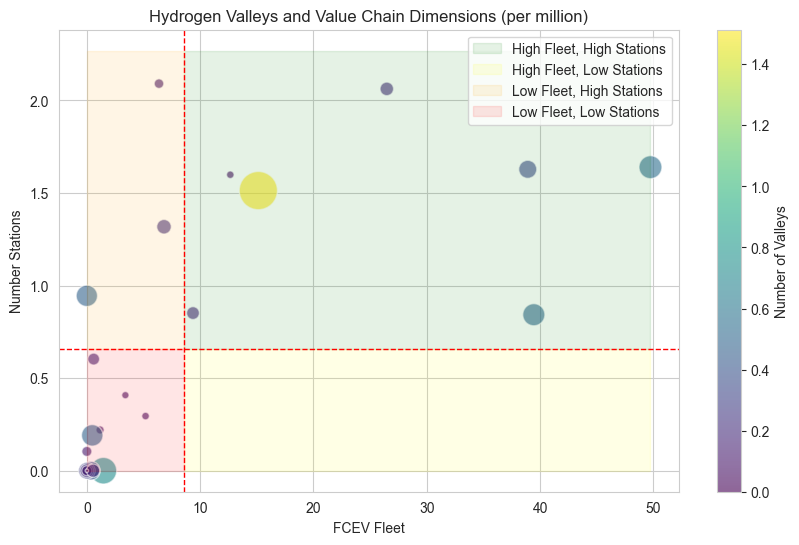

In [79]:
import matplotlib.patches as mpatches

data = per_million_df

# Define the dimensions and parameters
x_dimension = "FCEV Fleet"
y_dimension = "Number Stations"
size_dimension = "Number of Valleys"
color_dimension = "Number of Valleys"
size_scale_factor = 500
label_dimension = "Country"

# Bubble Chart
plt.figure(figsize=(10, 6))
bubble_chart = plt.scatter(
    x=data[x_dimension],
    y=data[y_dimension],
    s=data[size_dimension] * size_scale_factor,
    alpha=0.6,
    edgecolor="w",
    label=data[label_dimension],
    c=data[color_dimension],
    cmap='viridis'
)

# Adding labels and title
plt.title('Hydrogen Valleys and Value Chain Dimensions (per million)')
plt.xlabel(x_dimension)
plt.ylabel(y_dimension)
plt.colorbar(label=color_dimension)
plt.grid(True)

# Adding priority matrix lines
mean_x = data[x_dimension].mean()
mean_y = data[y_dimension].mean()

plt.axhline(y=mean_y, color='r', linestyle='--', linewidth=1)
plt.axvline(x=mean_x, color='r', linestyle='--', linewidth=1)

# Adding shaded regions
plt.fill_betweenx([0, mean_y], mean_x, data[x_dimension].max(), color='yellow', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], mean_x, data[x_dimension].max(), color='green', alpha=0.1)
plt.fill_betweenx([0, mean_y], data[x_dimension].min(), mean_x, color='red', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], data[x_dimension].min(), mean_x, color='orange', alpha=0.1)

# Creating legend
high_high_patch = mpatches.Patch(color='green', alpha=0.1, label='High Fleet, High Stations')
high_low_patch = mpatches.Patch(color='yellow', alpha=0.1, label='High Fleet, Low Stations')
low_high_patch = mpatches.Patch(color='orange', alpha=0.1, label='Low Fleet, High Stations')
low_low_patch = mpatches.Patch(color='red', alpha=0.1, label='Low Fleet, Low Stations')

plt.legend(handles=[high_high_patch, high_low_patch, low_high_patch, low_low_patch], loc='upper right')

# Displaying the chart
plt.show()

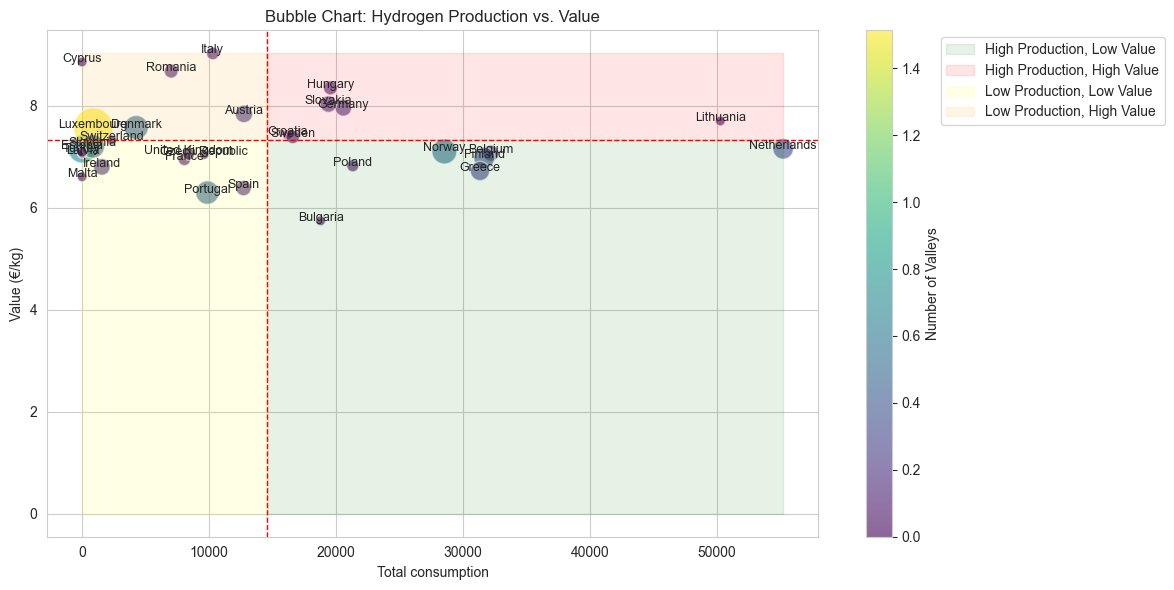

In [80]:
x_dimension = "Total consumption"
y_dimension = "Value (€/kg)"
size_dimension = "Number of Valleys"
color_dimension = "Number of Valleys"
size_scale_factor = 500
label_dimension = "Country"

# Bubble Chart
plt.figure(figsize=(10, 6))
bubble_chart = plt.scatter(
    x=data[x_dimension],
    y=data[y_dimension],
    s=(data[size_dimension] +0.1) * size_scale_factor,
    alpha=0.6,
    edgecolor="w",
    label=data[label_dimension],
    c=data[color_dimension],
    cmap='viridis'
)

# Adding country names to the bubbles
for i, country in enumerate(data[label_dimension]):
    plt.text(data[x_dimension][i], data[y_dimension][i], country, fontsize=9, ha='center')

# Adding labels and title
plt.title('Bubble Chart: Hydrogen Production vs. Value')
plt.xlabel(x_dimension)
plt.ylabel(y_dimension)
plt.colorbar(label=color_dimension)
plt.grid(True)

# Adding priority matrix lines
mean_x = data[x_dimension].mean()
mean_y = data[y_dimension].mean()

plt.axhline(y=mean_y, color='r', linestyle='--', linewidth=1)
plt.axvline(x=mean_x, color='r', linestyle='--', linewidth=1)

# Adding shaded regions
plt.fill_betweenx([0, mean_y], mean_x, data[x_dimension].max(), color='green', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], mean_x, data[x_dimension].max(), color='red', alpha=0.1)
plt.fill_betweenx([0, mean_y], data[x_dimension].min(), mean_x, color='yellow', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], data[x_dimension].min(), mean_x, color='orange', alpha=0.1)

# Creating legend
high_production_low_value_patch = mpatches.Patch(color='green', alpha=0.1, label='High Production, Low Value')
high_production_high_value_patch = mpatches.Patch(color='red', alpha=0.1, label='High Production, High Value')
low_production_low_value_patch = mpatches.Patch(color='yellow', alpha=0.1, label='Low Production, Low Value')
low_production_high_value_patch = mpatches.Patch(color='orange', alpha=0.1, label='Low Production, High Value')

plt.legend(handles=[high_production_low_value_patch, high_production_high_value_patch, low_production_low_value_patch, low_production_high_value_patch], loc='center left', bbox_to_anchor=(1.15, 0.9))

# Displaying the chart
plt.tight_layout(rect=[0, 0, 1.2, 1])  # Adjust layout to make room for the legend
plt.show()

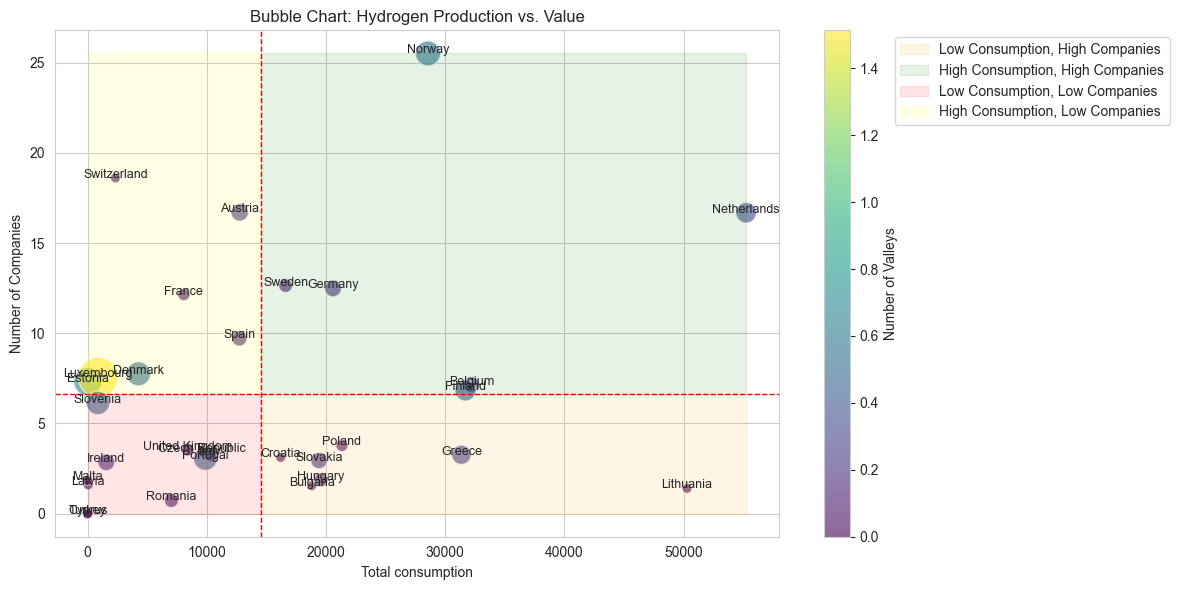

In [26]:
x_dimension = "Total consumption"
y_dimension = "Number of Companies"
size_dimension = "Number of Valleys"
color_dimension = "Number of Valleys"
size_scale_factor = 500
label_dimension = "Country"

# Bubble Chart
plt.figure(figsize=(10, 6))
bubble_chart = plt.scatter(
    x=data[x_dimension],
    y=data[y_dimension],
    s=(data[size_dimension] + 0.1) * size_scale_factor,
    alpha=0.6,
    edgecolor="w",
    label=data[label_dimension],
    c=data[color_dimension],
    cmap='viridis'
)

# Adding country names to the bubbles
for i, country in enumerate(data[label_dimension]):
    plt.text(data[x_dimension][i], data[y_dimension][i], country, fontsize=9, ha='center')

# Adding labels and title
plt.title('Bubble Chart: Hydrogen Production vs. Value')
plt.xlabel(x_dimension)
plt.ylabel(y_dimension)
plt.colorbar(label=color_dimension)
plt.grid(True)

# Adding priority matrix lines
mean_x = data[x_dimension].mean()
mean_y = data[y_dimension].mean()

plt.axhline(y=mean_y, color='r', linestyle='--', linewidth=1)
plt.axvline(x=mean_x, color='r', linestyle='--', linewidth=1)

# Adding shaded regions
plt.fill_betweenx([0, mean_y], mean_x, data[x_dimension].max(), color='orange', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], mean_x, data[x_dimension].max(), color='green', alpha=0.1)
plt.fill_betweenx([0, mean_y], data[x_dimension].min(), mean_x, color='red', alpha=0.1)
plt.fill_betweenx([mean_y, data[y_dimension].max()], data[x_dimension].min(), mean_x, color='yellow', alpha=0.1)

# Creating legend
low_consumption_high_companies_patch = mpatches.Patch(color='orange', alpha=0.1, label='Low Consumption, High Companies')
high_consumption_high_companies_patch = mpatches.Patch(color='green', alpha=0.1, label='High Consumption, High Companies')
low_consumption_low_companies_patch = mpatches.Patch(color='red', alpha=0.1, label='Low Consumption, Low Companies')
high_consumption_low_companies_patch = mpatches.Patch(color='yellow', alpha=0.1, label='High Consumption, Low Companies')

plt.legend(handles=[low_consumption_high_companies_patch, high_consumption_high_companies_patch, low_consumption_low_companies_patch, high_consumption_low_companies_patch], loc='center left', bbox_to_anchor=(1.15, 0.9))

# Displaying the chart
plt.tight_layout(rect=[0, 0, 1.2, 1])  # Adjust layout to make room for the legend
plt.show()

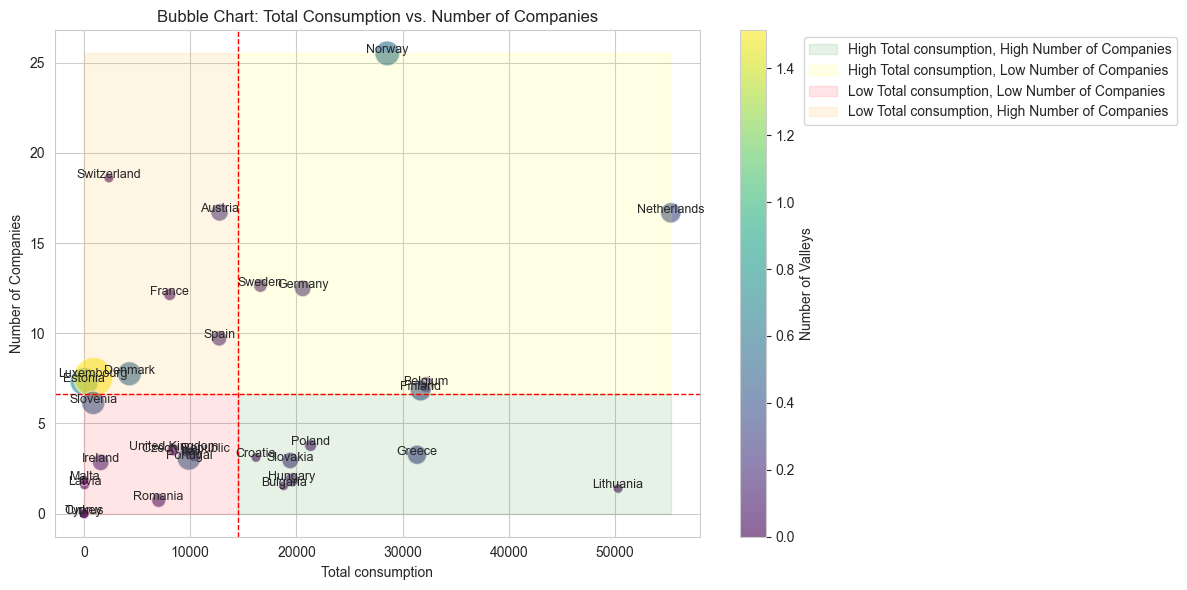

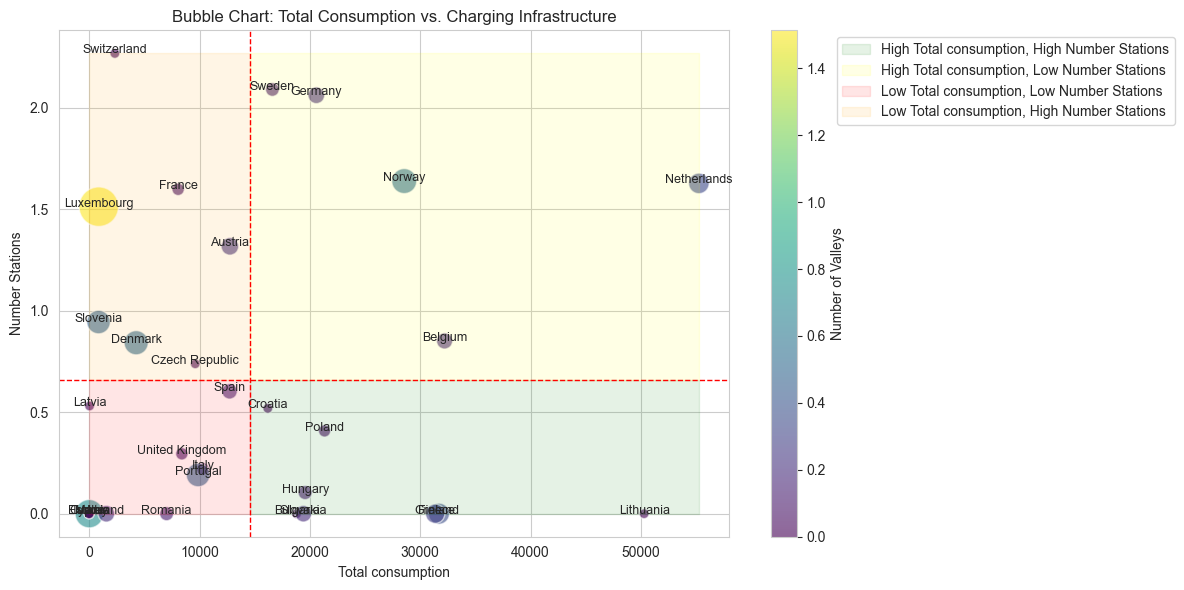

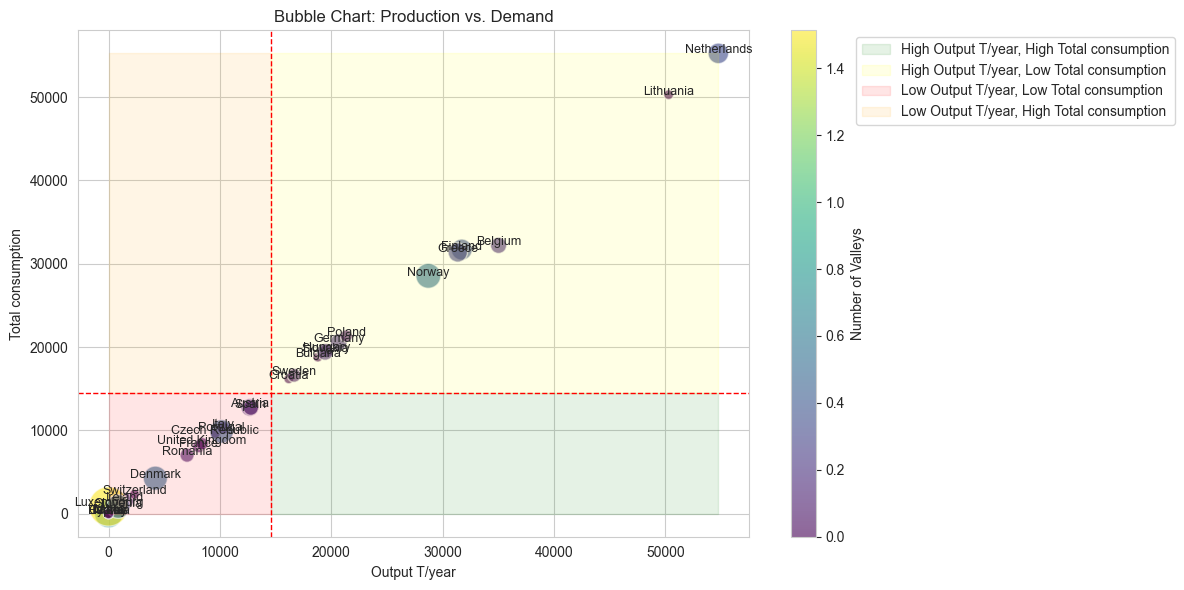

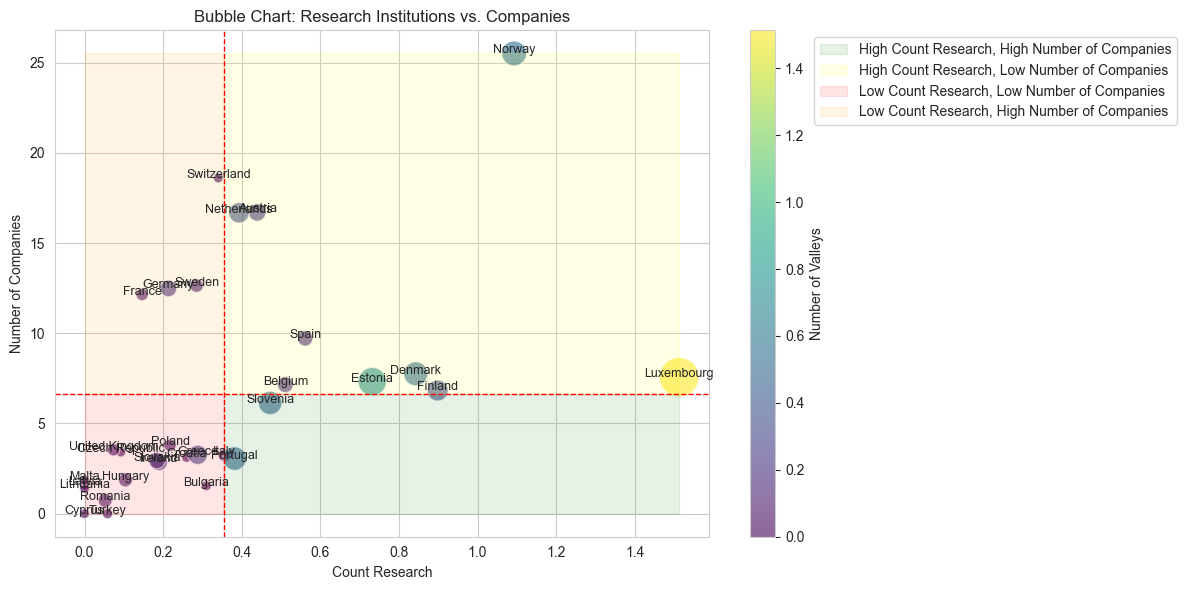

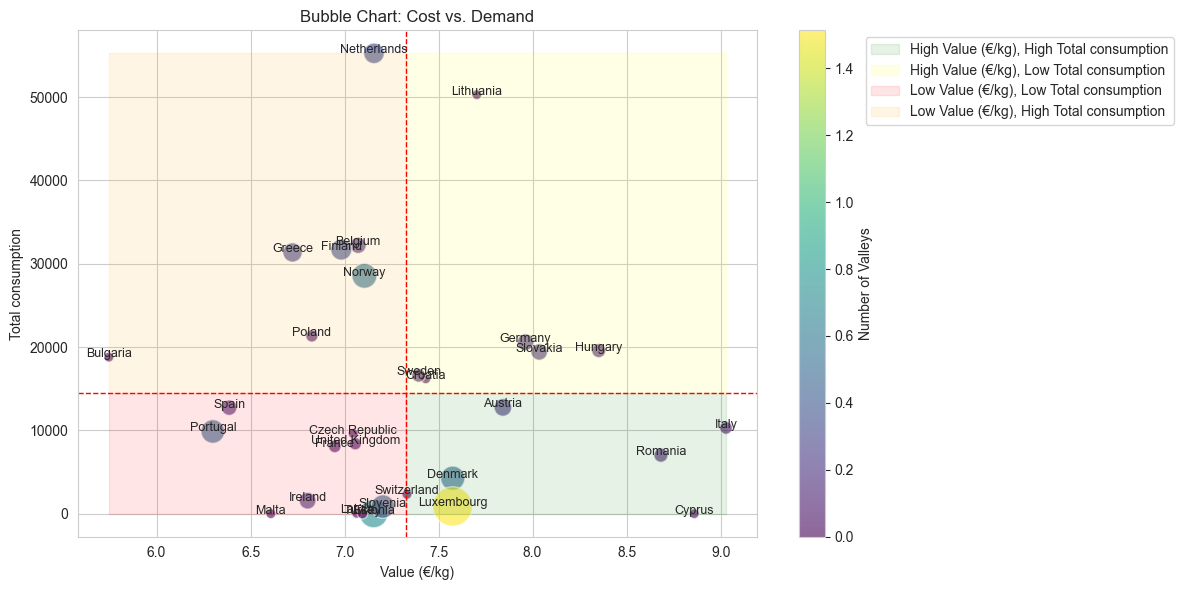

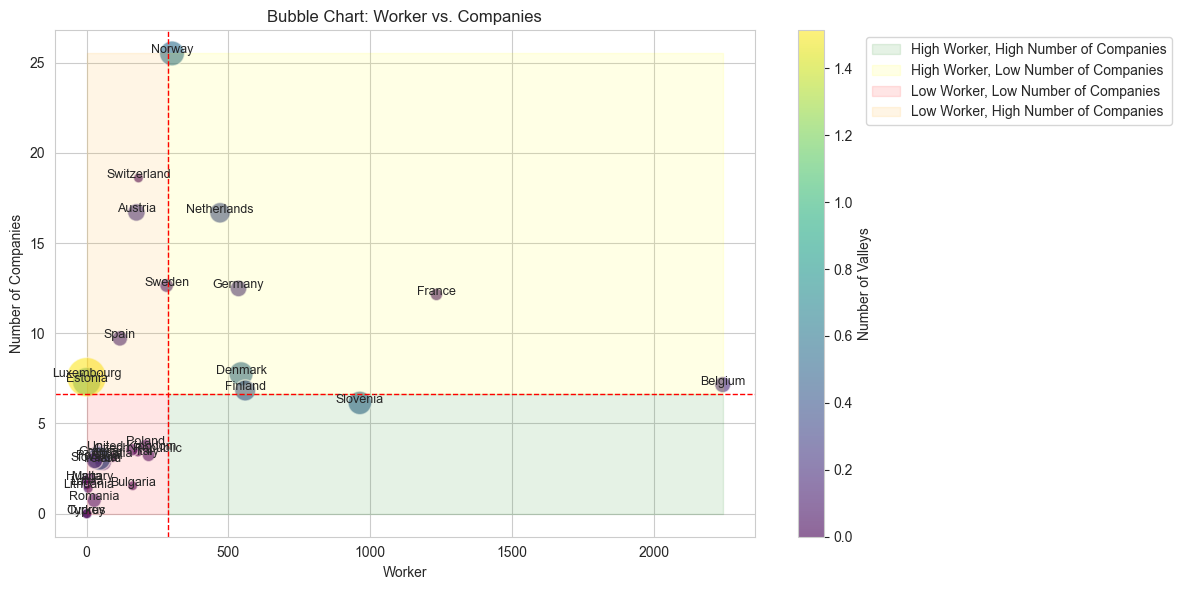

In [27]:

# Function to create bubble chart with priority matrix and save as PNG
def create_bubble_chart(x_dimension, y_dimension, size_dimension, color_dimension, title, filename):
    plt.figure(figsize=(10, 6))
    bubble_chart = plt.scatter(
        x=data[x_dimension],
        y=data[y_dimension],
        s=(data[size_dimension] + 0.1) * size_scale_factor,
        alpha=0.6,
        edgecolor="w",
        label=data[label_dimension],
        c=data[color_dimension],
        cmap='viridis'
    )

    # Adding country names to the bubbles
    for i, country in enumerate(data[label_dimension]):
        plt.text(data[x_dimension][i], data[y_dimension][i], country, fontsize=9, ha='center')

    # Adding labels and title
    plt.title(title)
    plt.xlabel(x_dimension)
    plt.ylabel(y_dimension)
    plt.colorbar(label=color_dimension)
    plt.grid(True)

    # Adding priority matrix lines
    mean_x = data[x_dimension].mean()
    mean_y = data[y_dimension].mean()

    plt.axhline(y=mean_y, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=mean_x, color='r', linestyle='--', linewidth=1)

    # Adding shaded regions
    plt.fill_betweenx([0, mean_y], mean_x, data[x_dimension].max(), color='green', alpha=0.1)
    plt.fill_betweenx([mean_y, data[y_dimension].max()], mean_x, data[x_dimension].max(), color='yellow', alpha=0.1)
    plt.fill_betweenx([0, mean_y], data[x_dimension].min(), mean_x, color='red', alpha=0.1)
    plt.fill_betweenx([mean_y, data[y_dimension].max()], data[x_dimension].min(), mean_x, color='orange', alpha=0.1)

    # Creating legend with dynamic descriptions
    high_x_high_y_patch = mpatches.Patch(color='green', alpha=0.1, label=f'High {x_dimension}, High {y_dimension}')
    high_x_low_y_patch = mpatches.Patch(color='yellow', alpha=0.1, label=f'High {x_dimension}, Low {y_dimension}')
    low_x_low_y_patch = mpatches.Patch(color='red', alpha=0.1, label=f'Low {x_dimension}, Low {y_dimension}')
    low_x_high_y_patch = mpatches.Patch(color='orange', alpha=0.1, label=f'Low {x_dimension}, High {y_dimension}')

    plt.legend(handles=[high_x_high_y_patch, high_x_low_y_patch, low_x_low_y_patch, low_x_high_y_patch], loc='center left', bbox_to_anchor=(1.15, 0.9))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1.2, 1])

    # Save the chart as a PNG file
    plt.savefig(filename, format='png')

    # Displaying the chart
    plt.show()

# Example usage
data = per_million_df
size_scale_factor = 500
label_dimension = "Country"

create_bubble_chart(
    x_dimension="Total consumption",
    y_dimension="Number of Companies",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Total Consumption vs. Number of Companies",
    filename="total_consumption_vs_number_of_companies.png"
)

create_bubble_chart(
    x_dimension="Total consumption",
    y_dimension="Number Stations",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Total Consumption vs. Charging Infrastructure",
    filename="total_consumption_vs_charging_infrastructure.png"
)

create_bubble_chart(
    x_dimension="Output T/year",
    y_dimension="Total consumption",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Production vs. Demand",
    filename="production_vs_demand.png"
)

create_bubble_chart(
    x_dimension="Count Research",
    y_dimension="Number of Companies",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Research Institutions vs. Companies",
    filename="research_institutions_vs_companies.png"
)

create_bubble_chart(
    x_dimension="Value (€/kg)",
    y_dimension="Total consumption",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Cost vs. Demand",
    filename="cost_vs_demand.png"
)

create_bubble_chart(
    x_dimension="Worker",
    y_dimension="Number of Companies",
    size_dimension="Number of Valleys",
    color_dimension="Number of Valleys",
    title="Bubble Chart: Worker vs. Companies",
    filename="worker_vs_companies.png"
)


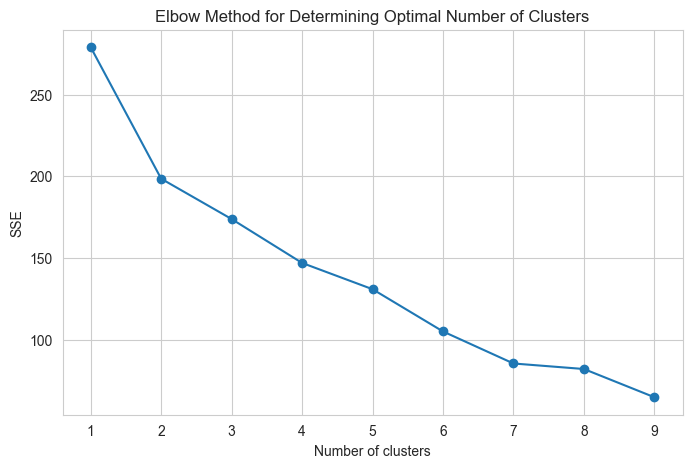

   Output T/year  Total consumption  Number Stations  FCEV Fleet       Worker  \
0   12682.617893       12753.204588         1.317990    6.809616   175.622190   
1   35019.737601       32204.006858         0.851586    9.367445  2243.247690   
2   18793.191001       18796.138133         0.000000    0.000000   162.693421   
3   16182.424930       16187.345053         0.519360    0.000000    92.186386   
4       0.000000           0.000000         0.000000    0.000000     0.000000   

   Number of Companies  Number of Valleys  Count Research  Value (€/kg)  \
0            16.694542           0.219665        0.439330      7.842083   
1             7.153322           0.170317        0.510952      7.071683   
2             1.550938           0.000000        0.310188      5.746098   
3             3.116160           0.000000        0.259680      7.431894   
4             0.000000           0.000000        0.000000      8.859940   

    Country  Cluster  
0   Austria        1  
1   Belgium     

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Extract the relevant data for clustering, keeping the 'Country' column for later use
dataset = data
data_for_clustering = data.drop(columns=['Country'])

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determine the number of clusters using the elbow method
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.show()

# Fit the final KMeans model with the optimal number of clusters (e.g., 3)
optimal_clusters = 3  # Adjust this number based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original dataset
dataset['Cluster'] = clusters

# Display the dataset with the cluster labels
print(data.head())

In [82]:
# Calculate summary statistics for each cluster, only for numeric columns
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
cluster_summary = dataset.groupby('Cluster')[numeric_columns].mean()

cluster_summary

,Output T/year,Total consumption,Number Stations,FCEV Fleet,Worker,Number of Companies,Number of Valleys,Count Research,Value (€/kg)
Cluster,,,,,,,,,
0,21233.471747,20913.574536,0.299862,1.602292,434.655939,5.021175,0.270001,0.437366,6.809602
1,16459.062129,16585.458261,1.662567,26.124019,414.129762,14.451965,0.385048,0.585226,7.432109
2,7671.598104,7675.324818,0.200755,1.110243,64.653239,2.096213,0.060135,0.114249,7.671897


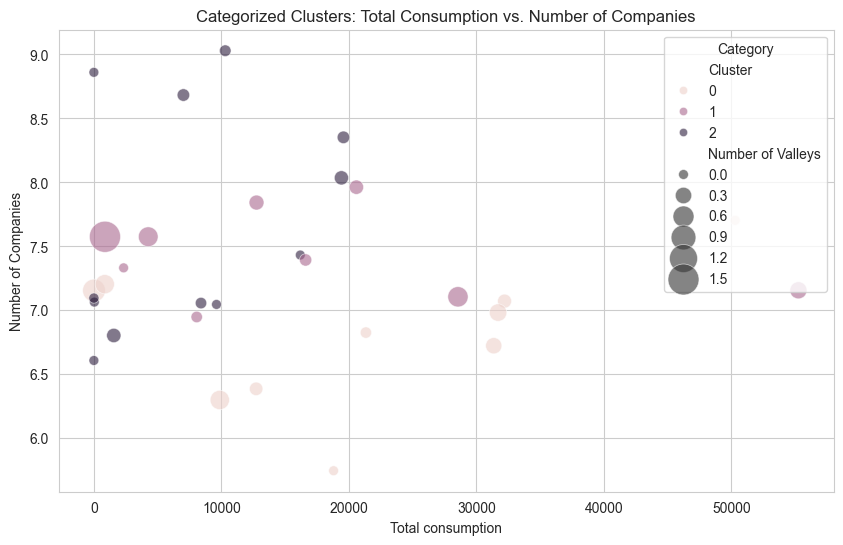

In [83]:
# Create a scatter plot with categories
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dataset,
    x="Total consumption",
    y="Value (€/kg)",
    size="Number of Valleys",
    hue="Cluster",
    sizes=(50, 500),
    alpha=0.6
)

# Adding labels and title
plt.title("Categorized Clusters: Total Consumption vs. Number of Companies")
plt.xlabel("Total consumption")
plt.ylabel("Number of Companies")
plt.legend(title='Category', loc='upper right')
plt.grid(True)

# Show the plot
plt.show()

In [42]:
dataset


,Output T/year,Total consumption,Number Stations,FCEV Fleet,Worker,Number of Companies,Number of Valleys,Number of Patents,Count Research,Value (€/kg),Country,Cluster,Category
0,12682.617893,12753.204588,1.317990,6.809616,175.622190,16.694542,0.219665,7.798109,0.439330,7.842083,Austria,2,Emerging
1,35019.737601,32204.006858,0.851586,9.367445,2243.247690,7.153322,0.170317,3.576661,0.510952,7.071683,Belgium,0,Developed
2,18793.191001,18796.138133,0.000000,0.000000,162.693421,1.550938,0.000000,20.162197,0.310188,5.746098,Bulgaria,0,Developed
3,16182.424930,16187.345053,0.519360,0.000000,92.186386,3.116160,0.000000,5.712959,0.259680,7.431894,Croatia,1,Underdeveloped
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.859940,Cyprus,1,Underdeveloped
5,9592.780982,9615.263401,0.738857,1.108286,180.742993,3.417216,0.000000,22.627508,0.092357,7.045749,Czech Republic,1,Underdeveloped
6,4206.017425,4262.760965,0.842793,39.442718,544.781476,7.753697,0.505676,19.552800,0.842793,7.575090,Denmark,2,Emerging
7,12.342826,12.342826,0.000000,1.464253,0.000000,7.321266,0.732127,0.732127,0.732127,7.154682,Estonia,2,Emerging
8,31710.413241,31696.273208,0.000000,0.359456,559.492593,6.829656,0.359456,14.378223,0.898639,6.982303,Finland,0,Developed
9,8109.119903,8064.022372,1.598874,12.658975,1233.773318,12.145575,0.058674,16.091420,0.146686,6.947785,France,2,Emerging
